In [1]:
%matplotlib inline
import matplotlib
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, requests, pickle
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy.io import fits
from astropy import units as u
from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from alerts import get_alerts
from astropy.time import Time

In [4]:
alerts = get_alerts()
m = ~alerts.retracted
alert_coords = SkyCoord(alerts[m]['RA'], alerts[m]['Dec'], unit='deg')

cols = ['3FHL Name', '4FGL Name', 'Fermi ra', 'Fermi dec', 'Counterpart', 'Counterpart ra', 'Counterpart dec', 'Counterpart prob']
#fermi_matches = {k: list() for k in cols}
fermi_matches = pd.DataFrame(columns=cols)

for cat, fn in zip(['3FHL', '4FGL'], ["data/gll_psch_v13.fit", "data/gll_psc_v27.fit"]):

    fermi_3fhl = fits.open(fn)
    tab = fermi_3fhl[1]
    fermi_ra = tab.data["RAJ2000"]
    fermi_dec = tab.data["DEJ2000"]
    fermi_coords = SkyCoord(fermi_ra, fermi_dec, unit='deg')

    for j, (i, r) in enumerate(alerts[m].iterrows()):

        #if r.Event != 'IC200911A':
        #    continue

        c = SkyCoord(r['RA'], r['Dec'], unit='deg')
        delta_ra = fermi_coords.ra - c.ra
        delta_dec = fermi_coords.dec - c.dec

        try:    
            if r['Dec Unc (rectangle) float']:
                dec_unc = Angle(r['Dec Unc (rectangle) float']*u.deg)

                if r.Event == "IC190629A":
                    ra_unc = Angle([360, 360]*u.deg)
                else:
                    ra_unc = Angle(r['RA Unc (rectangle) float']*u.deg)

                match_mask = (delta_dec <= max(dec_unc)) & (delta_dec >= min(dec_unc)) & (delta_ra <= max(ra_unc)) & (delta_ra >= min(ra_unc))

            else:
                print(r)
                _sep = Angle(r["initial Error90 [arcmin]"] * u.arcmin)
                sep = c.separation(fermi_coords)
                match_mask = sep <= _sep

        except TypeError as e:
            print(r, "\n", e)

        #test_m = sep**2 == delta_dec**2 + delta_ra**2
        #if not np.all(test_m):
        #    raise Exception(r)

        _matches = tab.data[match_mask]
        
        if cat == '4FGL':
            matches = np.array([
                _matches["ASSOC_FHL"], 
                _matches['Source_Name'], 
                _matches['RAJ2000'], 
                _matches['DEJ2000'],
                _matches['ASSOC1'],
                _matches['RA_Counterpart'],
                _matches['DEC_Counterpart'],
                np.minimum(np.array(_matches['ASSOC_PROB_BAY']).astype(float), np.array(_matches['ASSOC_PROB_LR']).astype(float))
            ]).T
            columns = cols
            
        else:
            matches = np.array([
                _matches['Source_Name'], 
                _matches['RAJ2000'], 
                _matches['DEJ2000'],
                _matches['ASSOC1']
            ]).T
            columns = [f"{cat} Name", "Fermi ra", "Fermi dec", 'Counterpart']
        
        if len(_matches) > 0:
            print(f"{len(_matches)} matches in {cat} for {r.Event}")
            l = np.array([(r.Event, cat, j) for j in range(len(_matches))]).T
            index = pd.MultiIndex.from_arrays(l)
            ifermi_matches = pd.DataFrame(matches, columns=columns, index=index)
            fermi_matches = fermi_matches.append(ifermi_matches)
    
fermi_matches = pd.DataFrame(fermi_matches, 
                             index=pd.MultiIndex.from_tuples(fermi_matches.index,
                                                            names=['Event', 'Fermi Cat', 'Macth ind']))

1 matches in 3FHL for IC170922A
1 matches in 3FHL for IC181014A
Event                                     IC190504A
Class                                          HESE
RA                                          65.7866
RA Unc (rectangle)                              NaN
Dec                                        -37.4431
Dec Unc (rectangle)                             NaN
arrival time [UT]            2019-05-04 18:25:18.39
Signalness                                 0.439614
initial RA                                  65.7866
initial Dec                                -37.4431
initial Error90 [arcmin]                      73.79
retracted                                     False
RA Unc (rectangle) float                       None
Dec Unc (rectangle) float                      None
2h coverage                                     NaN
14d coverage                                    NaN
observed                                      False
Name: 46, dtype: object
2 matches in 3FHL for IC1905

### Math the 3FHL and the 4FGL Catalogues and remove the duplicat entries ###

In [5]:
drop_m = fermi_matches['3FHL Name'].duplicated(keep=False) & fermi_matches['4FGL Name'].isna()
print(f"found {len(fermi_matches[drop_m])} duplicates")
fermi_matches = fermi_matches[~drop_m]
print(len(fermi_matches))
print(len(fermi_matches[fermi_matches["4FGL Name"].isna() & (~fermi_matches["3FHL Name"].isna())]))

for x in ['ra', 'dec']:
    counterpart = fermi_matches[f"Counterpart {x}"]
    fermi = fermi_matches[f"Fermi {x}"]
    xm = (~counterpart.isna()) & (np.array(fermi_matches['Counterpart prob']).astype(float) > 0)
    fermi_matches[x] = fermi
    fermi_matches.loc[xm, x] = counterpart[xm]
    
has_cp = ~np.isnan(np.array(fermi_matches['Counterpart dec']).astype(float))

for k in ['Counterpart', 'Counterpart ra', 'Counterpart dec']:
    fermi_matches.loc[~has_cp, k] = ""

ncp = len(fermi_matches[has_cp])
print(f"{ncp} with counterpart, {len(fermi_matches) - ncp} without")
fermi_matches.to_csv('data/fermi_matches.csv')    
fermi_matches

found 55 duplicates
177
0
139 with counterpart, 38 without


3FHL Name           4FGL Name  \
Event     Fermi Cat Macth ind                                           
IC161103A 4FGL      0                              4FGL J0244.7+1316    
IC170922A 4FGL      0          3FHL J0509.4+0542   4FGL J0509.4+0542    
IC181014A 4FGL      0          3FHL J1457.5-3538   4FGL J1457.4-3539    
                    1                              4FGL J1505.0-3433    
IC181023A 4FGL      0                              4FGL J1804.4-0852    
...                                           ...                 ...   
IC210608A 4FGL      14                             4FGL J2248.9+2106    
IC210717A 4FGL      0                              4FGL J0256.2-0408    
                    1          3FHL J0304.5-0055   4FGL J0304.5-0054    
                    2                              4FGL J0307.8-0419    
IC210730A 4FGL      0                              4FGL J0659.7+1416    

                               Fermi ra Fermi dec  \
Event     Fermi Cat Macth ind                       
IC161103A 4FGL      0            41.192   13.2799   
IC170922A 4FGL      0           77.3593    5.7014   
IC181014A 4FGL      0          224.3657  -35.6527   
                    1          226.2581  -34.5546   
IC181023A 4FGL      0          271.1182   -8.8694   
...                                 ...       ...   
IC210608A 4FGL      14         342.2461   21.1159   
IC210717A 4FGL      0           44.0544    -4.134   
                    1           46.1423   -0.9148   
                    2           46.9523   -4.3266   
IC210730A 4FGL      0          104.9416   14.2792   

                                                Counterpart  \
Event     Fermi Cat Macth ind                                 
IC161103A 4FGL      0          GB6 J0244+1320                 
IC170922A 4FGL      0          TXS 0506+056                   
IC181014A 4FGL      0          PKS 1454-354                   
                    1          PMN J1505-3432                 
IC181023A 4FGL      0                                         
...                                                     ...   
IC210608A 4FGL      14         PKS 2246+208                   
IC210717A 4FGL      0                                         
                    1          RX J0304.5-0054                
                    2          LEDA 095522                    
IC210730A 4FGL      0          PSR J0659+1414                 

                                  Counterpart ra     Counterpart dec  \
Event     Fermi Cat Macth ind                                          
IC161103A 4FGL      0              41.1903889042          13.3353393   
IC170922A 4FGL      0              77.3581852833       5.69314818611   
IC181014A 4FGL      0               224.36129875      -35.6527698861   
                    1              226.259876379      -34.5491167778   
IC181023A 4FGL      0                                                  
...                                          ...                 ...   
IC210608A 4FGL      14             342.252361346          21.1174543   
IC210717A 4FGL      0                                                  
                    1              46.1414966667         -0.90130895   
                    2              46.9354854083      -4.31923459167   
IC210730A 4FGL      0          104.9505615234375  14.239310264587402   

                                 Counterpart prob                 ra  \
Event     Fermi Cat Macth ind                                          
IC161103A 4FGL      0                         0.0             41.192   
IC170922A 4FGL      0          0.9901848435401917      77.3581852833   
IC181014A 4FGL      0           0.994556725025177       224.36129875   
                    1          0.9717896580696106      226.259876379   
IC181023A 4FGL      0                         0.0           271.1182   
...                                           ...                ...   
IC210608A 4FGL      14         0.9745596051216125      342.25236134

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec Counterpart prob     ra     dec
                   4FGL J0244.7+1316    41.192   13.2799 GB6 J0244+1320                41.1903889042      13.3353393              0.0 41.192 13.2799


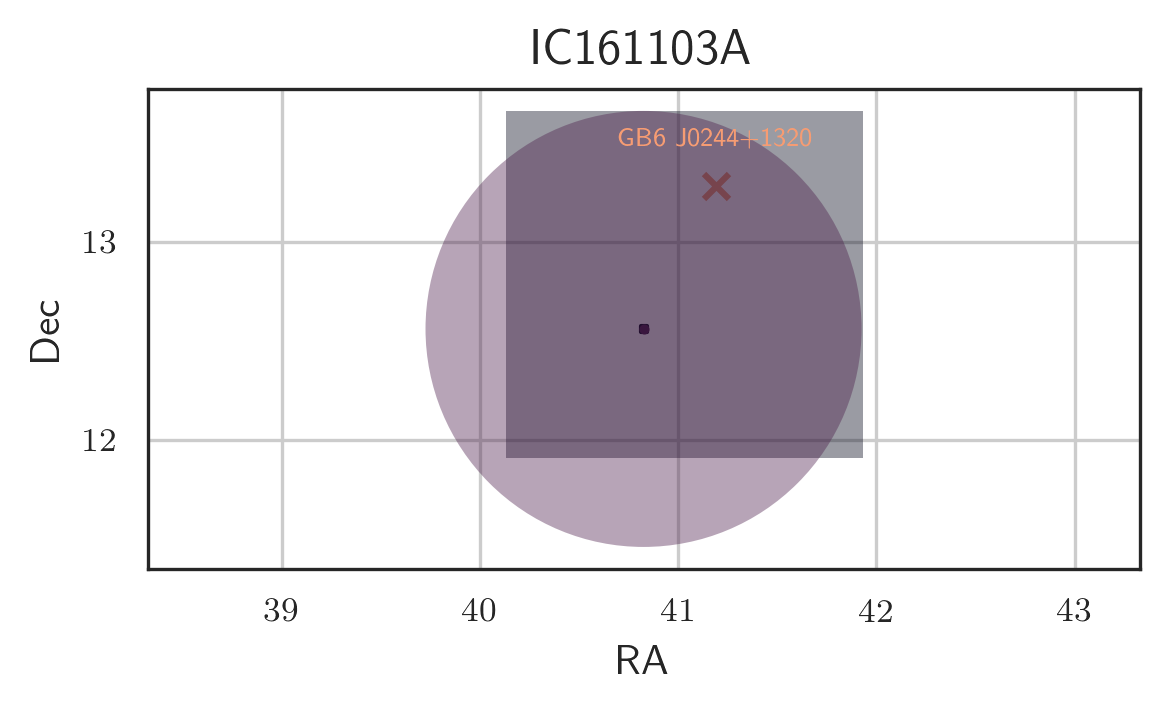

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
3FHL J0509.4+0542  4FGL J0509.4+0542   77.3593    5.7014 TXS 0506+056                  77.3581852833   5.69314818611 0.9901848435401917 77.3581852833 5.69314818611


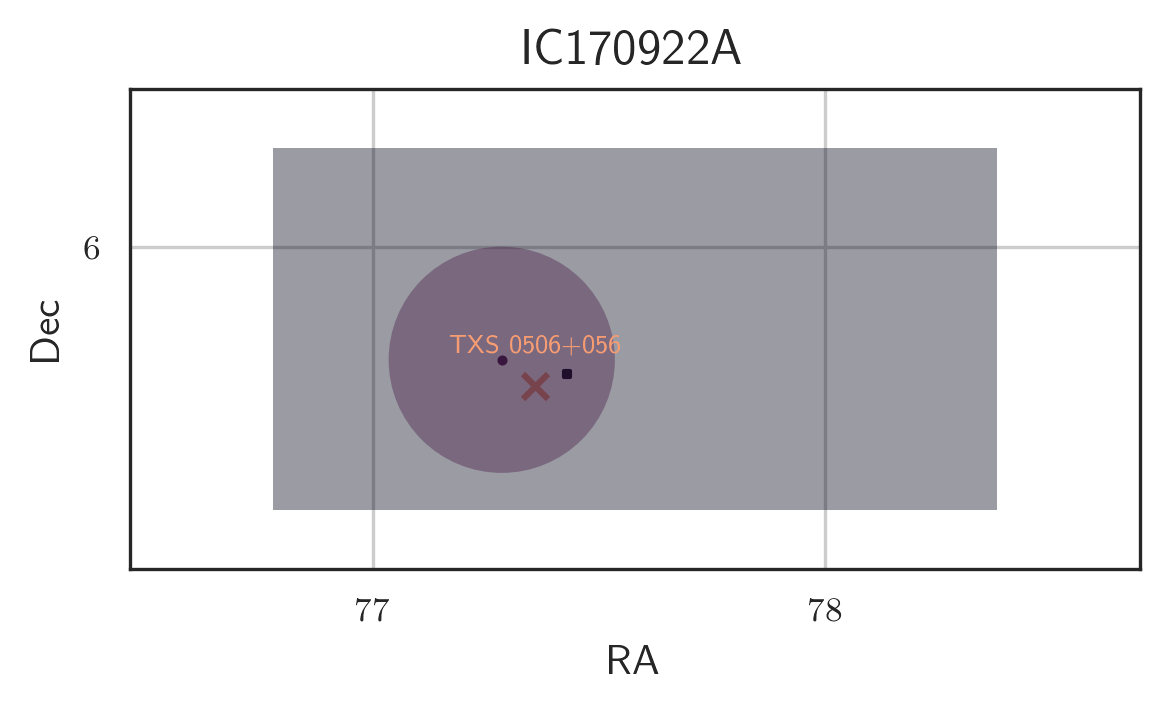

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra            dec
3FHL J1457.5-3538  4FGL J1457.4-3539  224.3657  -35.6527 PKS 1454-354                   224.36129875  -35.6527698861  0.994556725025177  224.36129875 -35.6527698861
                   4FGL J1505.0-3433  226.2581  -34.5546 PMN J1505-3432                226.259876379  -34.5491167778 0.9717896580696106 226.259876379 -34.5491167778


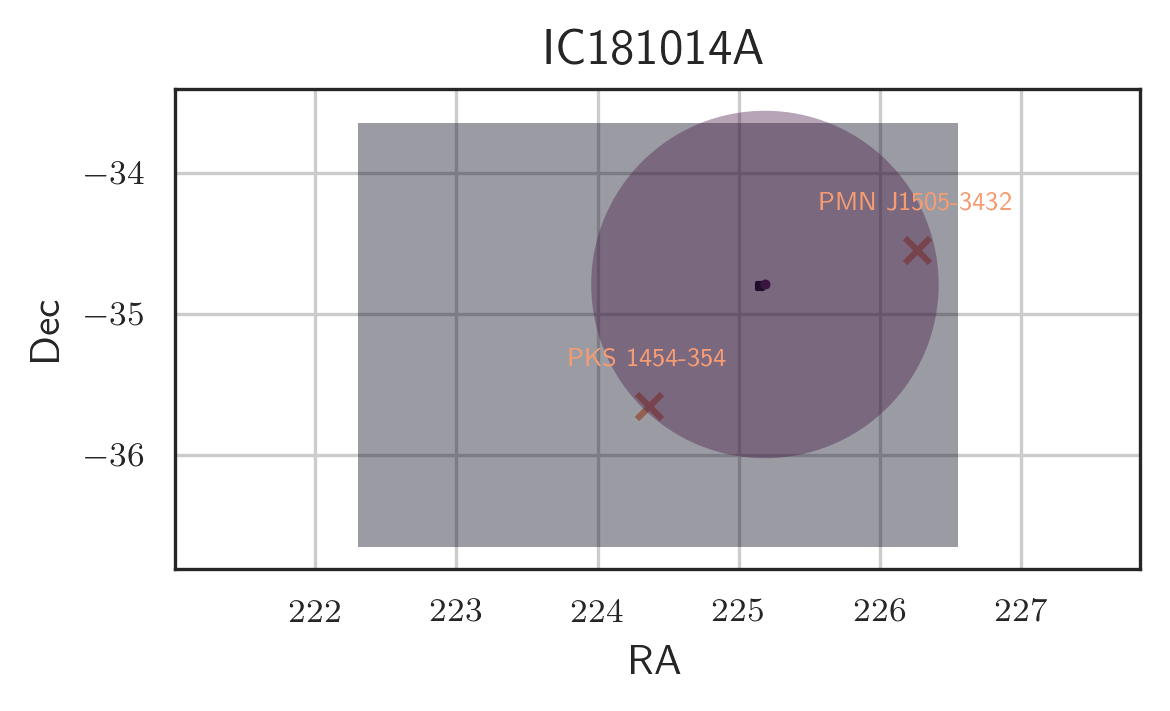

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart    Counterpart ra    Counterpart dec Counterpart prob       ra     dec
                   4FGL J1804.4-0852  271.1182   -8.8694                                                                                0.0 271.1182 -8.8694
                   4FGL J1805.8-0803  271.4509    -8.066 1RXS J180603.1-080612        271.5129089355469 -8.103469848632812              0.0 271.4509  -8.066


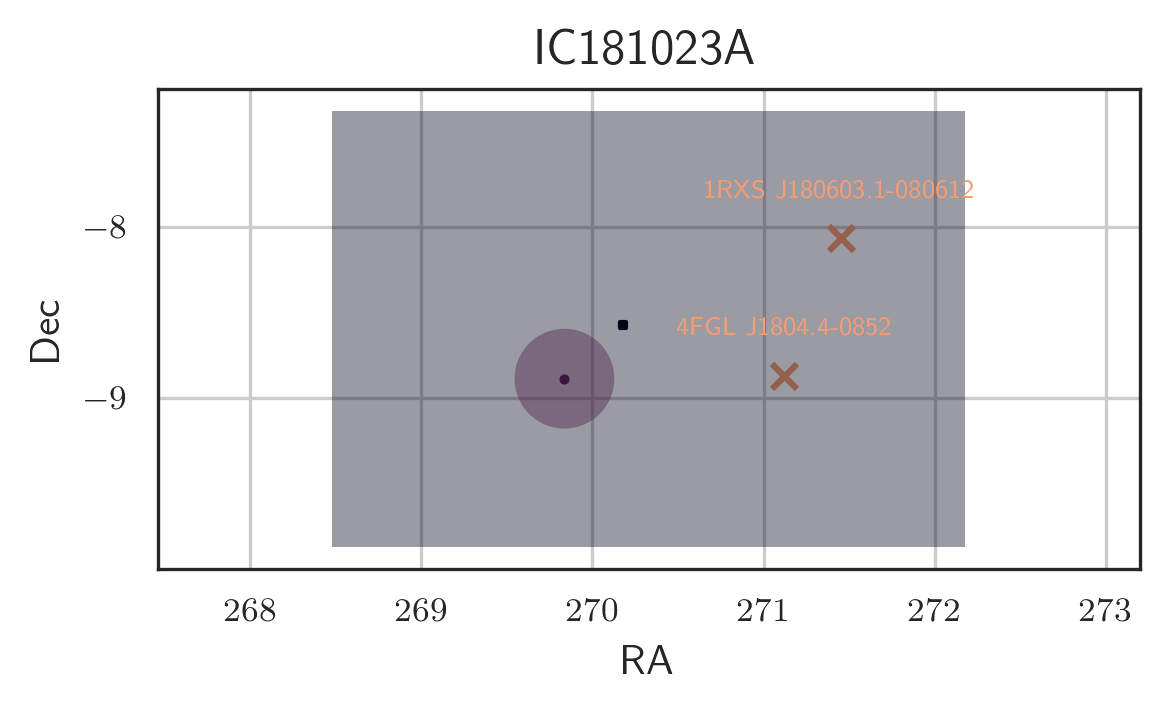

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra            dec
                   4FGL J2351.4-2818  357.8686  -28.3116                                                                            0.0      357.8686       -28.3116
                   4FGL J2358.1-2853  359.5498  -28.8936 PMN J2358-2853                359.570714825  -28.8928064306 0.9362704157829285 359.570714825 -28.8928064306


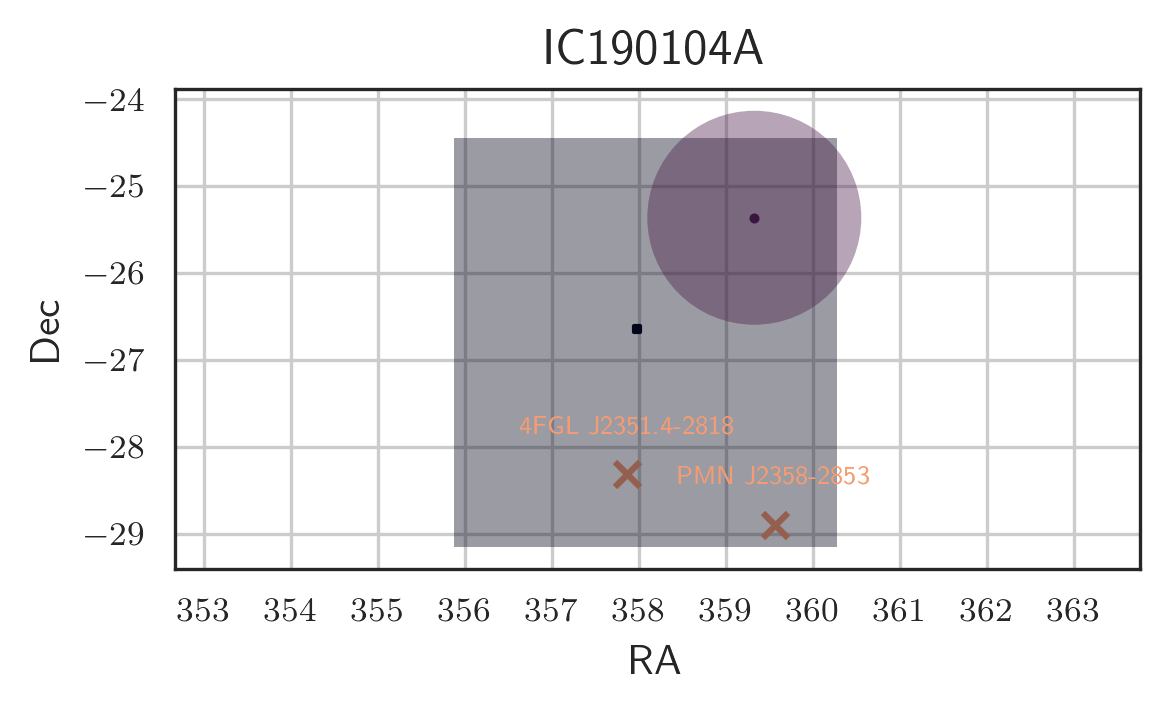

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart    Counterpart ra     Counterpart dec   Counterpart prob                ra                 dec
                   4FGL J1750.4-1721  267.6032  -17.3606                                                                                   0.0          267.6032            -17.3606
                   4FGL J1758.7-1621   269.685  -16.3556 AT20G J175841-161703         269.6709899902344 -16.284250259399414 0.8351255059242249 269.6709899902344 -16.284250259399414


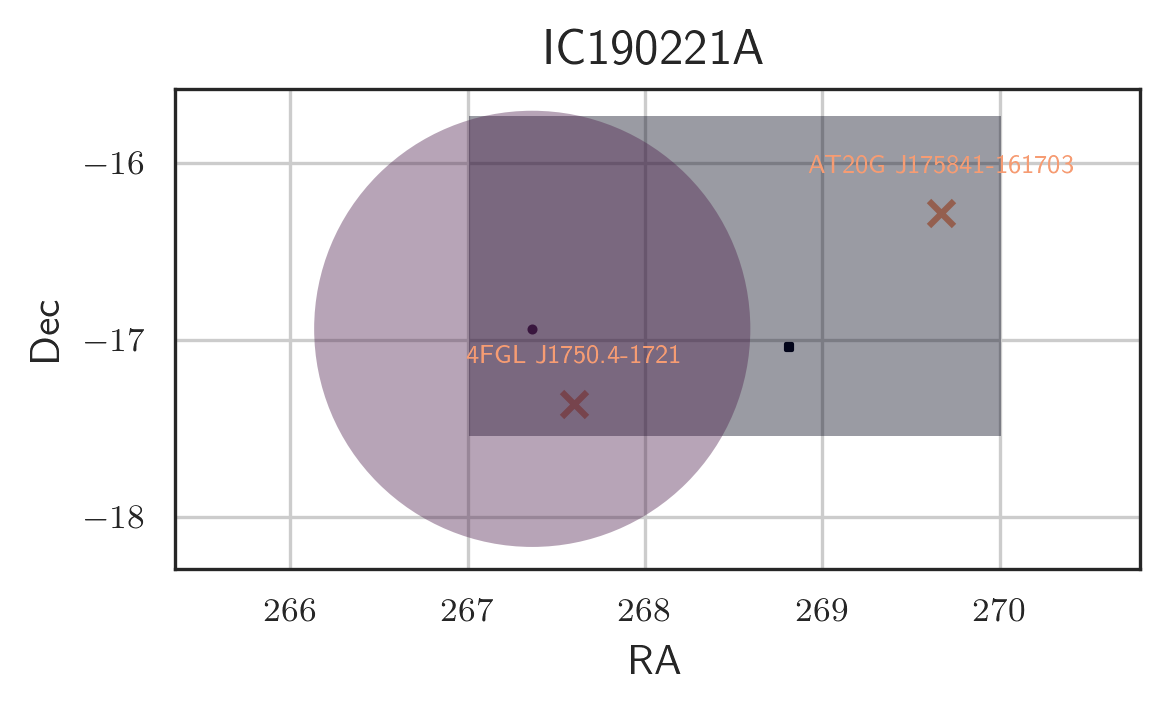

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra            dec
3FHL J0420.4-3744  4FGL J0420.3-3745   65.0936  -37.7522 NVSS J042025-374443           65.1045999083  -37.7457942139 0.9239774346351624 65.1045999083 -37.7457942139
3FHL J0428.6-3756  4FGL J0428.6-3756    67.173  -37.9403 PKS 0426-380                  67.1684344625  -37.9387723944 0.9997910857200623 67.1684344625 -37.9387723944
Event                                     IC190504A
Class                                          HESE
RA                                          65.7866
RA Unc (rectangle)                              NaN
Dec                                        -37.4431
Dec Unc (rectangle)                             NaN
arrival time [UT]            2019-05-04 18:25:18.39
Signalness                                 0.439614
initial RA                                  65.7866
initial Dec                          

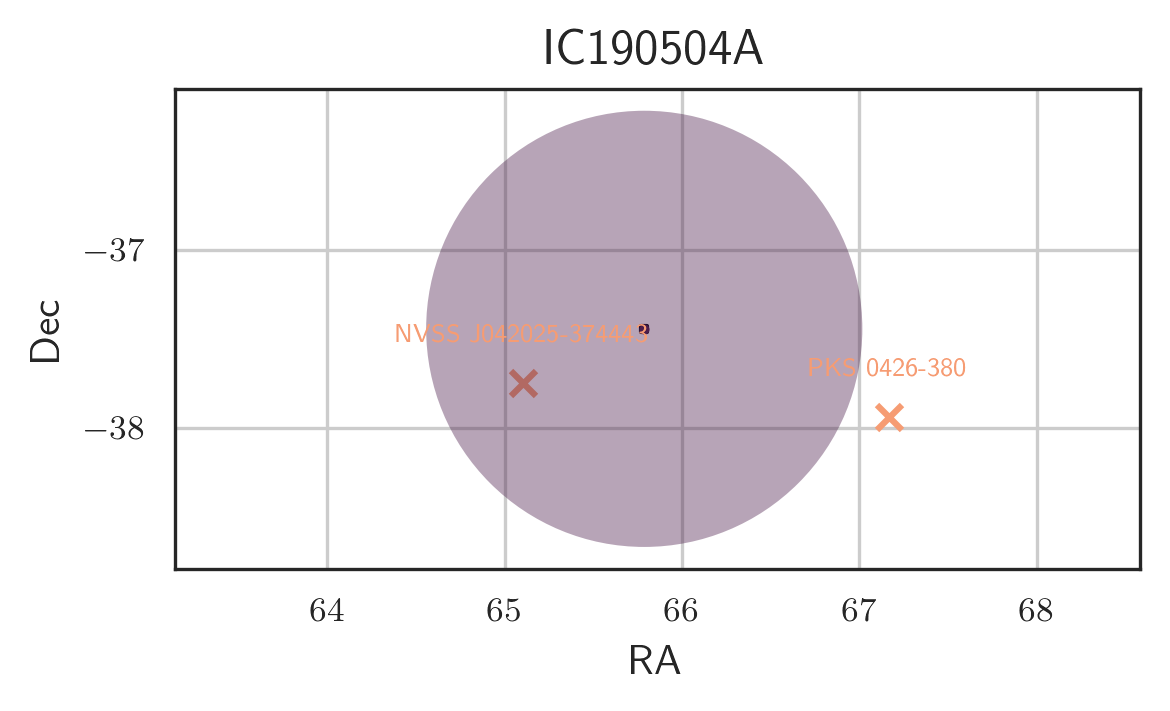

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J2306.6+0940  346.6505    9.6732                                                                            0.0      346.6505        9.6732
                   4FGL J2308.9+1111  347.2481   11.1992 MG1 J230850+1112              347.215934742   11.1970812417 0.8303675651550293 347.215934742 11.1970812417


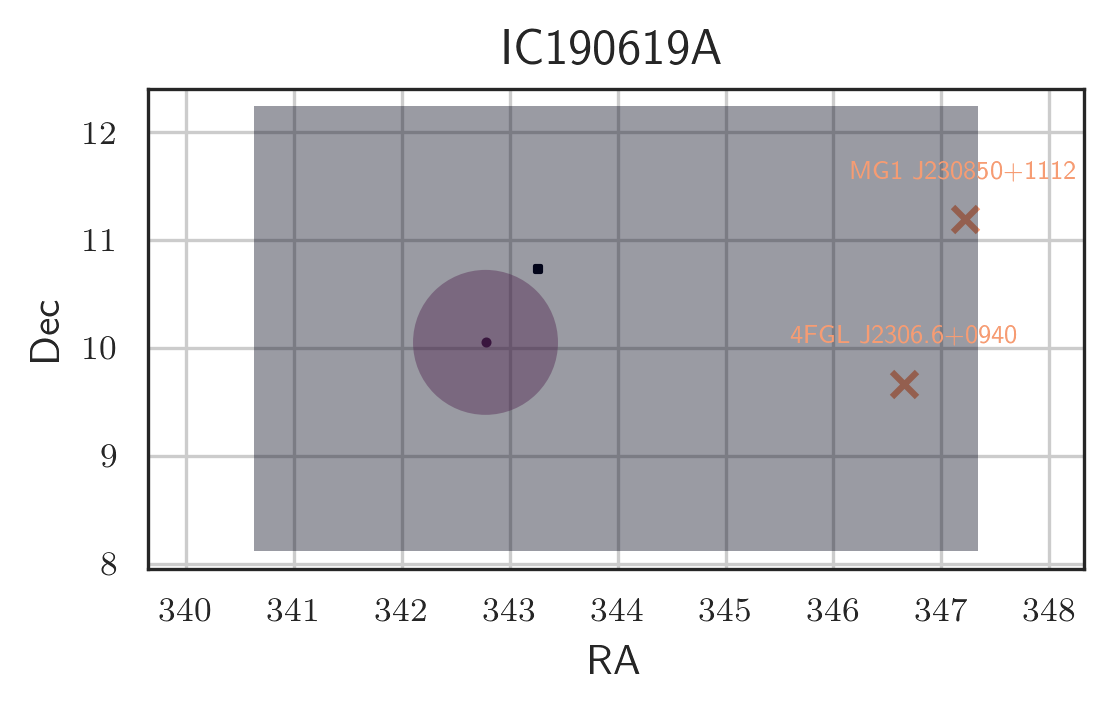

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart  Counterpart ra    Counterpart dec Counterpart prob       ra     dec
                   4FGL J1045.3+2751  161.3406   27.8515 NVSS J104516+275136          161.31787109375 27.859277725219727              0.0 161.3406 27.8515
                   4FGL J1049.8+2741  162.4574   27.6846                                                                              0.0 162.4574 27.6846


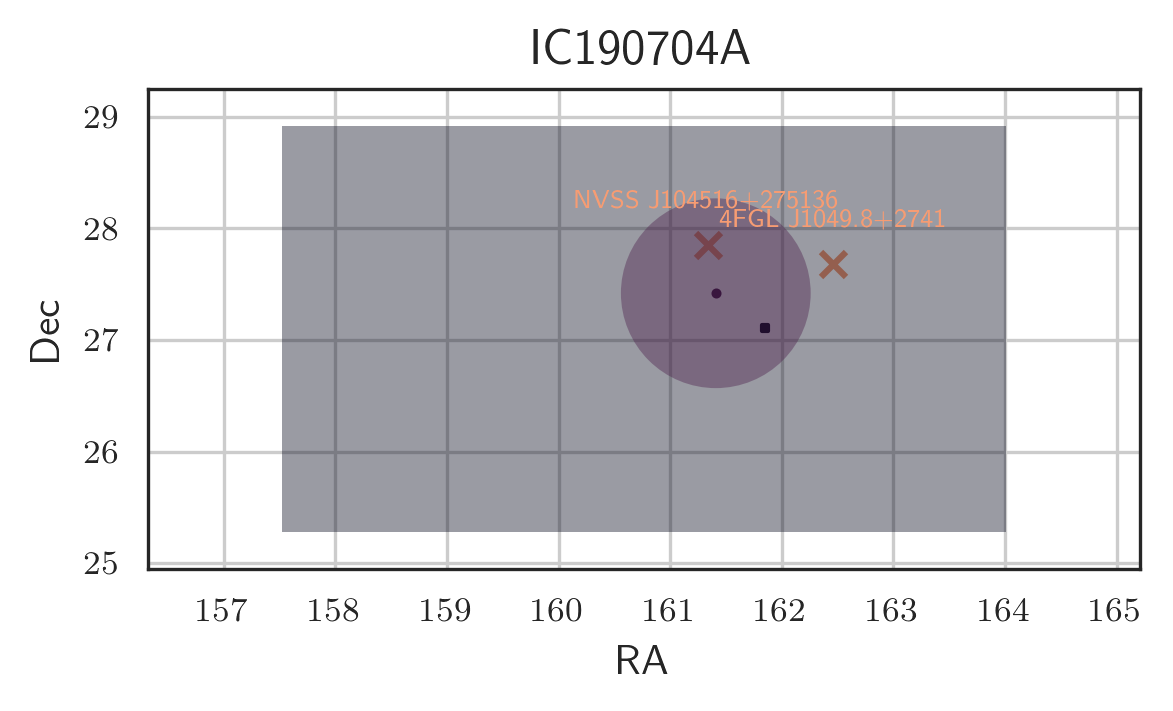

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart    Counterpart ra    Counterpart dec   Counterpart prob                ra                dec
                   4FGL J0440.4+1440   70.1151   14.6823 TXS 0437+145                     70.0880808375      14.6324865556                0.0           70.1151            14.6823
3FHL J0441.6+1504  4FGL J0441.5+1505   70.3896   15.0909 1RXS J044127.8+150455        70.36419677734375 15.082200050354004 0.9874110817909241 70.36419677734375 15.082200050354004
                   4FGL J0445.7+1535   71.4362   15.5985                                                                                  0.0           71.4362            15.5985
                   4FGL J0449.1+1121   72.2823   11.3569 PKS 0446+11                      72.2819629375      11.3579434444 0.9928092360496521     72.2819629375      11.3579434444
3FHL J0458.0+1151  4FGL J0458.0+1152   74.5069   11.8727 NVSS J045804+115142              74.5203826792  

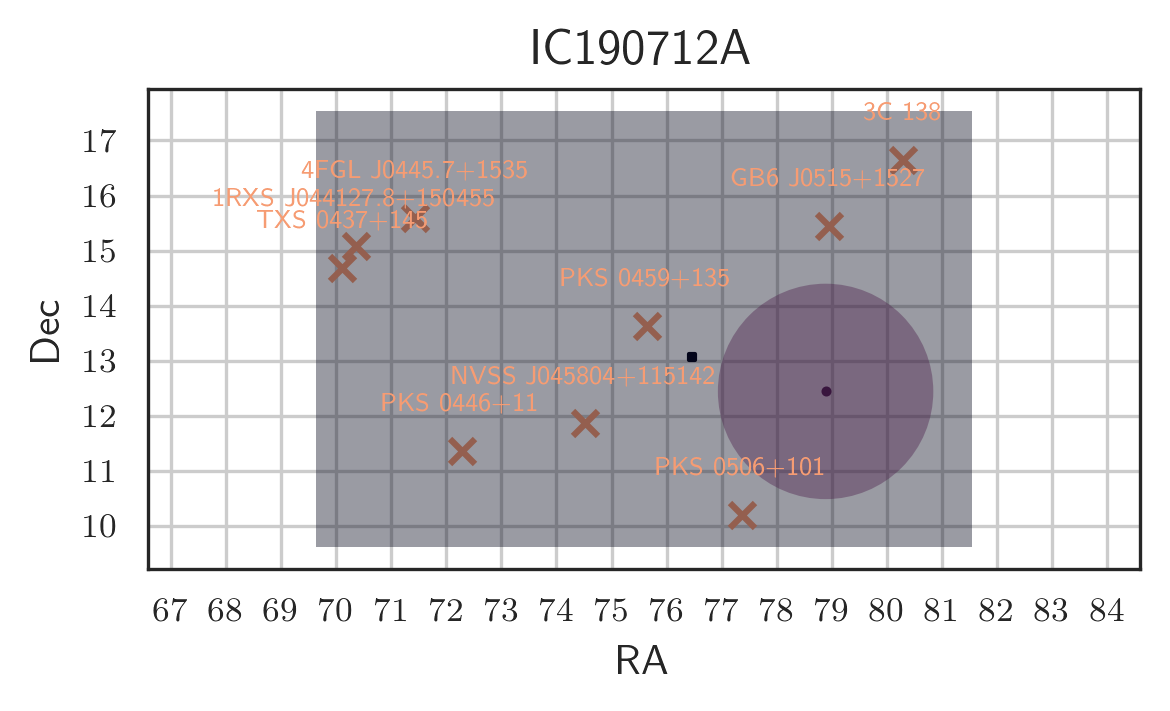

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
3FHL J1504.3+1030  4FGL J1504.4+1029  226.1033   10.4978 PKS 1502+106                  226.104082425   10.4942218083 0.9984732866287231 226.104082425 10.4942218083


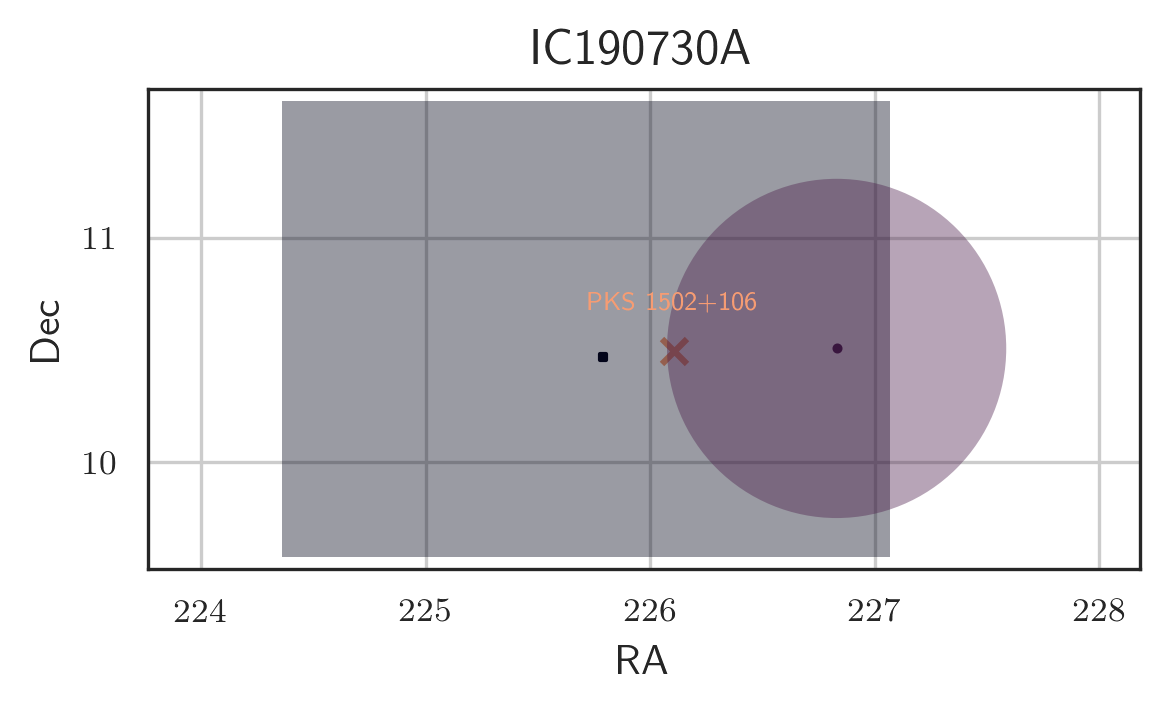

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart    Counterpart ra   Counterpart dec   Counterpart prob                ra               dec
3FHL J0946.2+0104  4FGL J0946.2+0104  146.5672    1.0701 1RXS J094620.5+010459            146.584237304     1.08113655833 0.9516786336898804     146.584237304     1.08113655833
                   4FGL J1003.4+0205  150.8627    2.0877 SDSS J100326.63+020455.6     150.8607940673828 2.082200050354004 0.8986677527427673 150.8607940673828 2.082200050354004


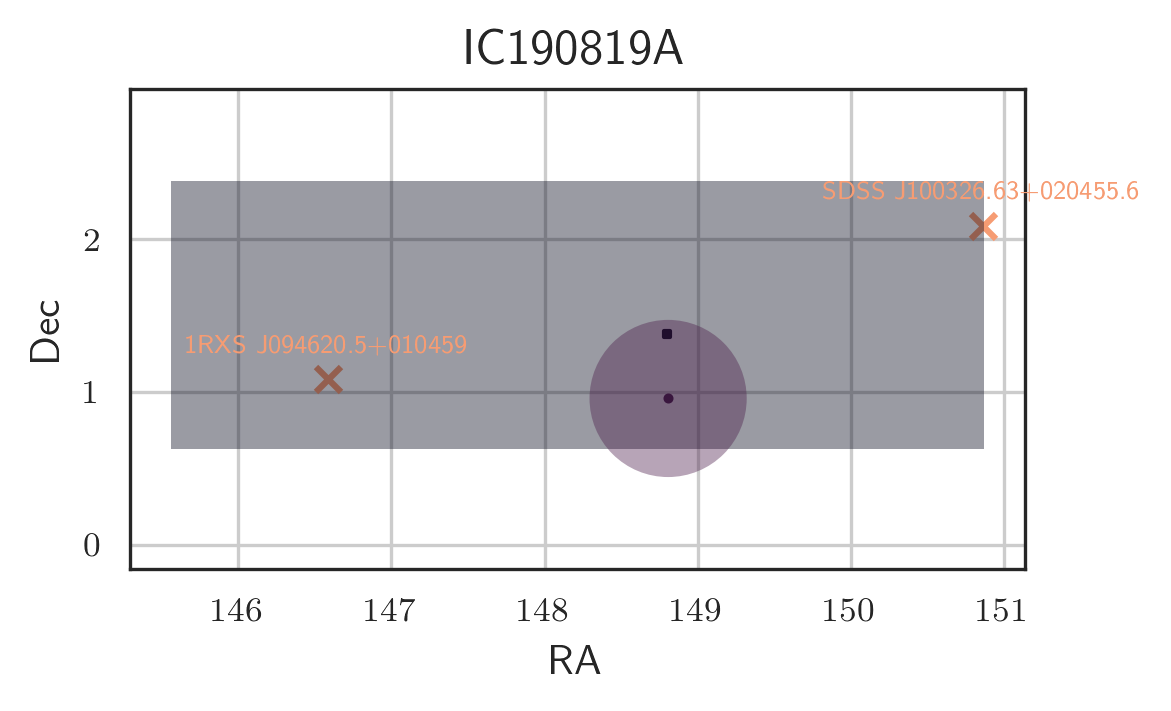

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J1100.0-2044   165.017  -20.7439                                                                            0.0       165.017      -20.7439
3FHL J1103.6-2328  4FGL J1103.6-2329  165.9091  -23.4957 1ES 1101-232                  165.906729271   -23.492000525 0.9956713318824768 165.906729271 -23.492000525
                   4FGL J1120.0-2204  170.0016  -22.0779                                                                            0.0      170.0016      -22.0779


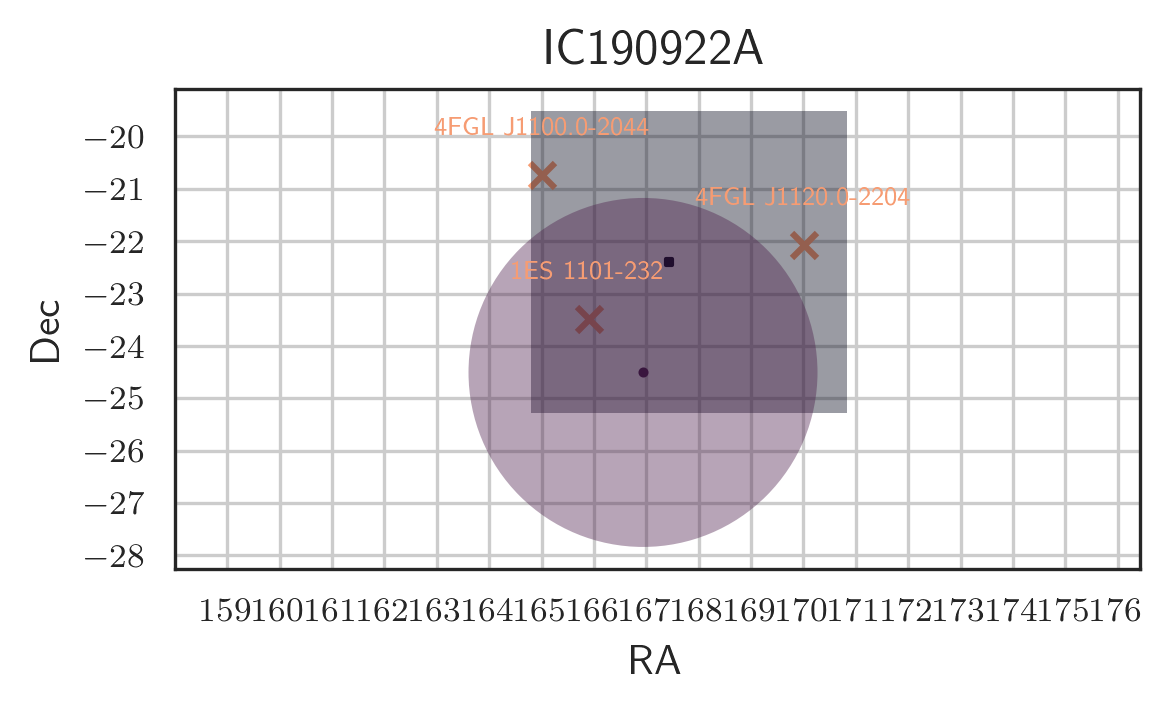

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart    Counterpart ra    Counterpart dec Counterpart prob       ra     dec
                   4FGL J2052.7+1218  313.1937   12.3162 PSR J2052+1218               313.1990661621094 12.333060264587402              0.0 313.1937 12.3162
3FHL J2115.2+1218  4FGL J2115.2+1218  318.8169   12.3027 NVSS J211522+121802              318.841663042      12.3007799667              nan 318.8169 12.3027
                   4FGL J2117.0+1344  319.2575   13.7449                                                                                0.0 319.2575 13.7449


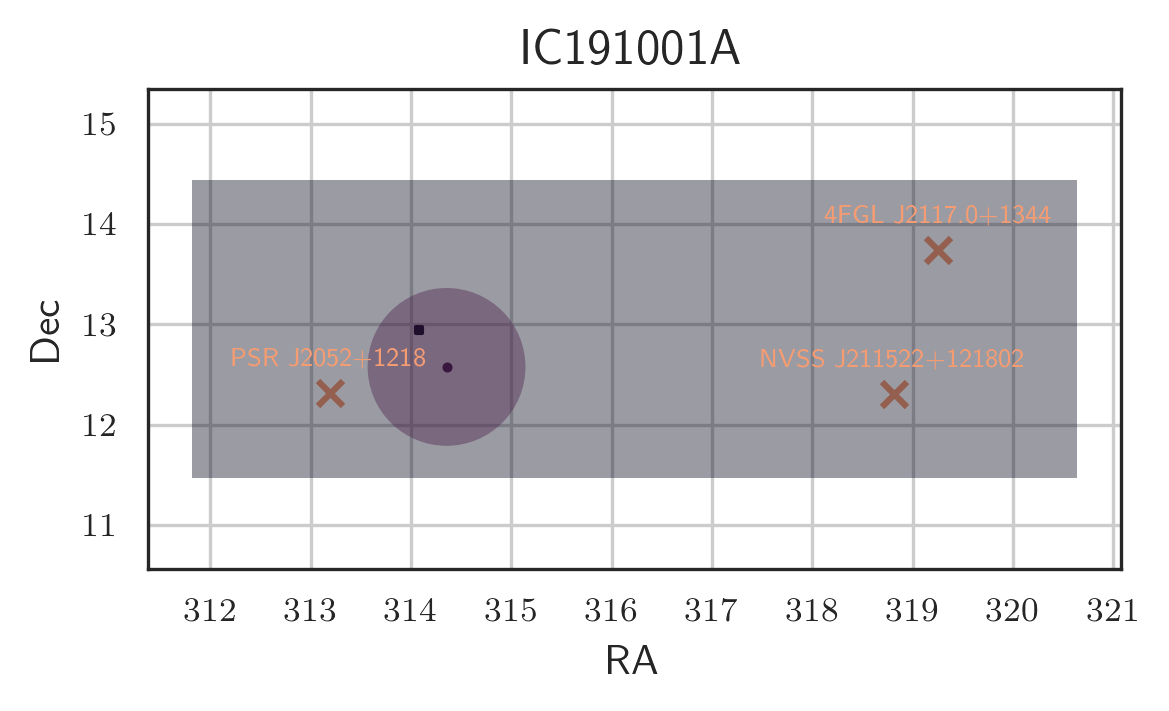

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart     Counterpart ra    Counterpart dec   Counterpart prob            ra           dec
                   4FGL J1455.0+0247  223.7616    2.7958 87GB 145233.9+030210           223.781005859375 2.8444700241088867                0.0      223.7616        2.7958
                   4FGL J1502.6+0207  225.6523    2.1285                                                                                   0.0      225.6523        2.1285
                   4FGL J1505.0+0326  226.2726    3.4472 PKS 1502+036                      226.276988158      3.44189237222                0.0      226.2726        3.4472
                   4FGL J1510.9+0551  227.7398    5.8562                                                                                   0.0      227.7398        5.8562
3FHL J1512.2+0203  4FGL J1512.2+0202  228.0702    2.0403 PKS 1509+022                      228.065590604      2.05471645833 0.9897345304489136 22

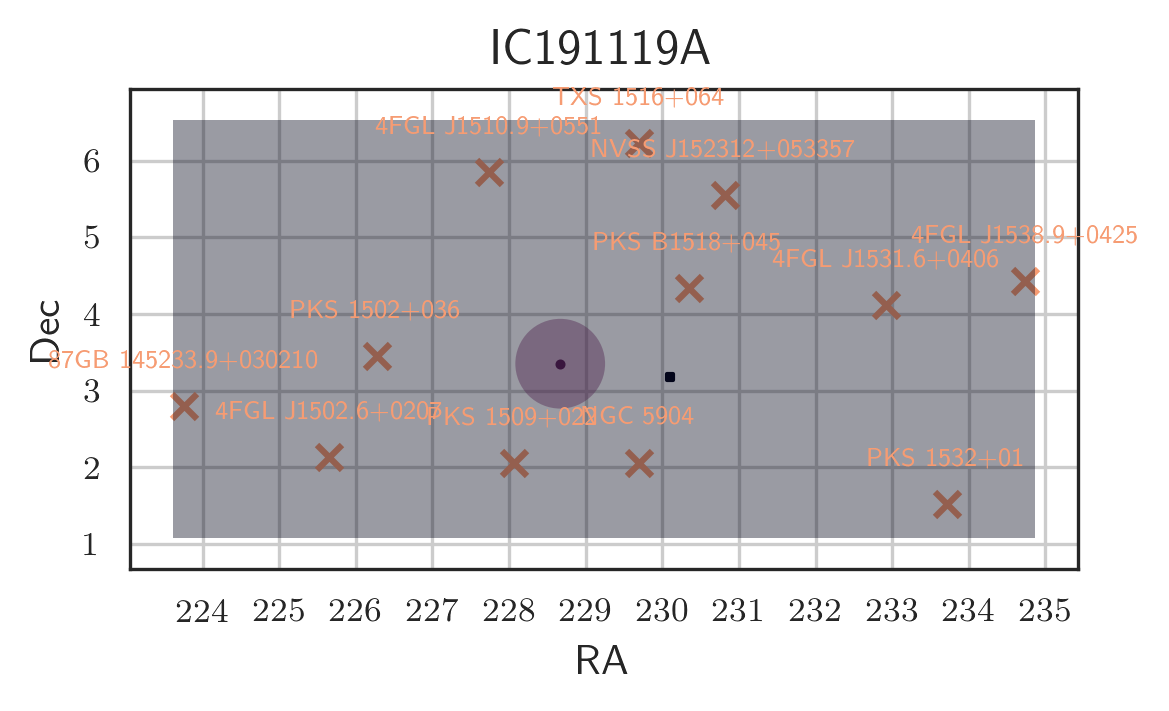

         3FHL Name          4FGL Name Fermi ra Fermi dec Counterpart Counterpart ra Counterpart dec Counterpart prob      ra    dec
                   4FGL J0154.6+0051   28.6607    0.8619                                                         0.0 28.6607 0.8619


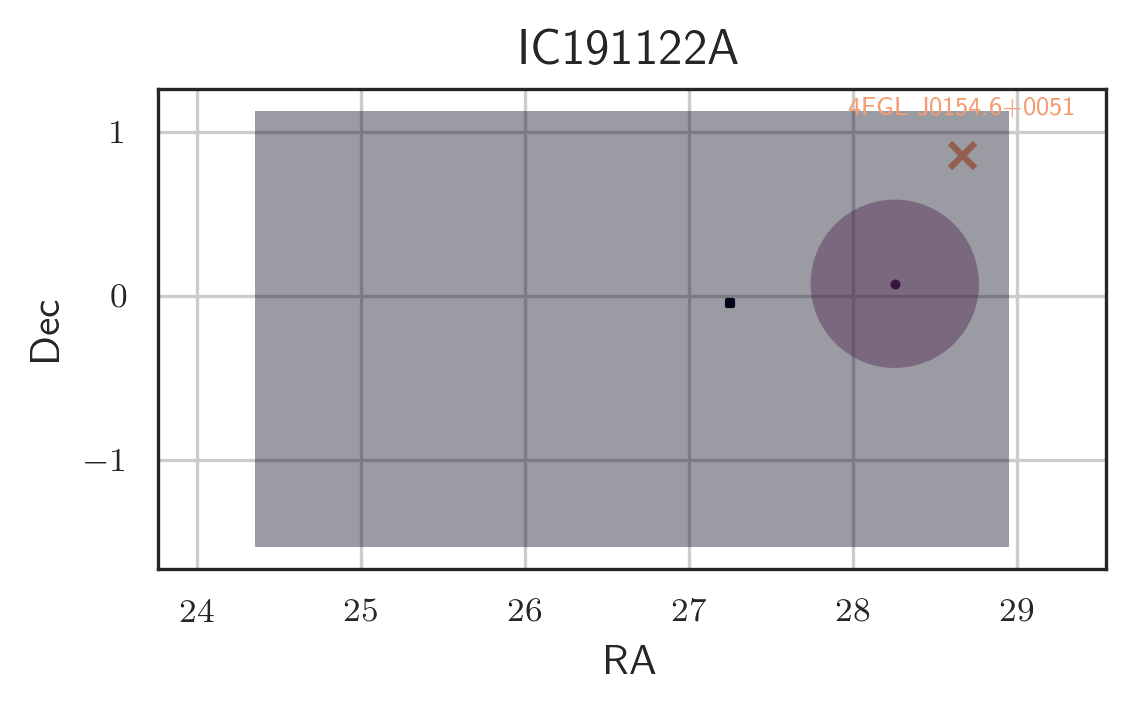

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec Counterpart prob       ra    dec
                   4FGL J1858.7+5708  284.6974    57.146 87GB 185759.9+570427          284.722921929   57.1360225028              0.0 284.6974 57.146


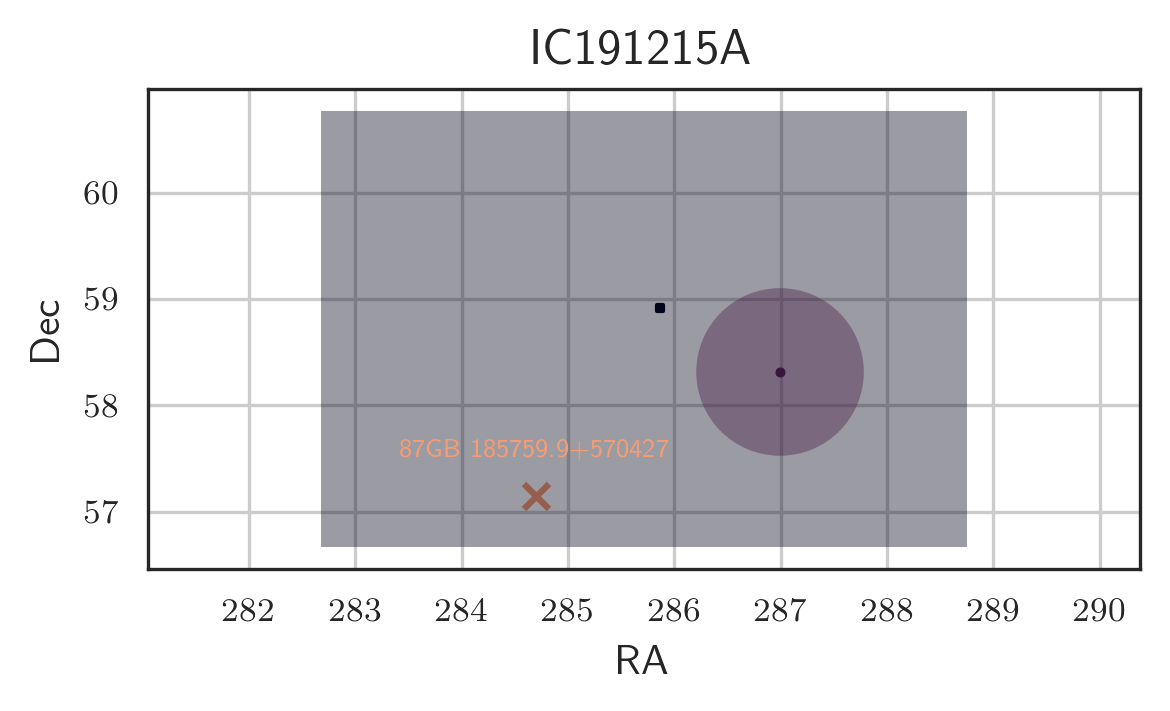

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J0258.1+2030   44.5422   20.5137 MG3 J025805+2029              44.5304559125   20.5004389361 0.9223970174789429 44.5304559125 20.5004389361
                   4FGL J0259.5+1924   44.8791   19.4082 TXS 0256+192                  44.8735664167   19.4289798722  0.866802453994751 44.8735664167 19.4289798722
3FHL J0312.7+2013  4FGL J0312.7+2012   48.1994   20.2164                                                                            0.0       48.1994       20.2164
3FHL J0318.8+2135  4FGL J0318.7+2135   49.6946   21.5968 MG3 J031849+2135              49.6902892083   21.5768570278 0.8679142594337463 49.6902892083 21.5768570278
3FHL J0319.8+1845  4FGL J0319.8+1845   49.9722   18.7532 1E 0317.0+1835                49.9658678375   18.7596008611 0.9930770993232727 49.9658678375 18.7596008611


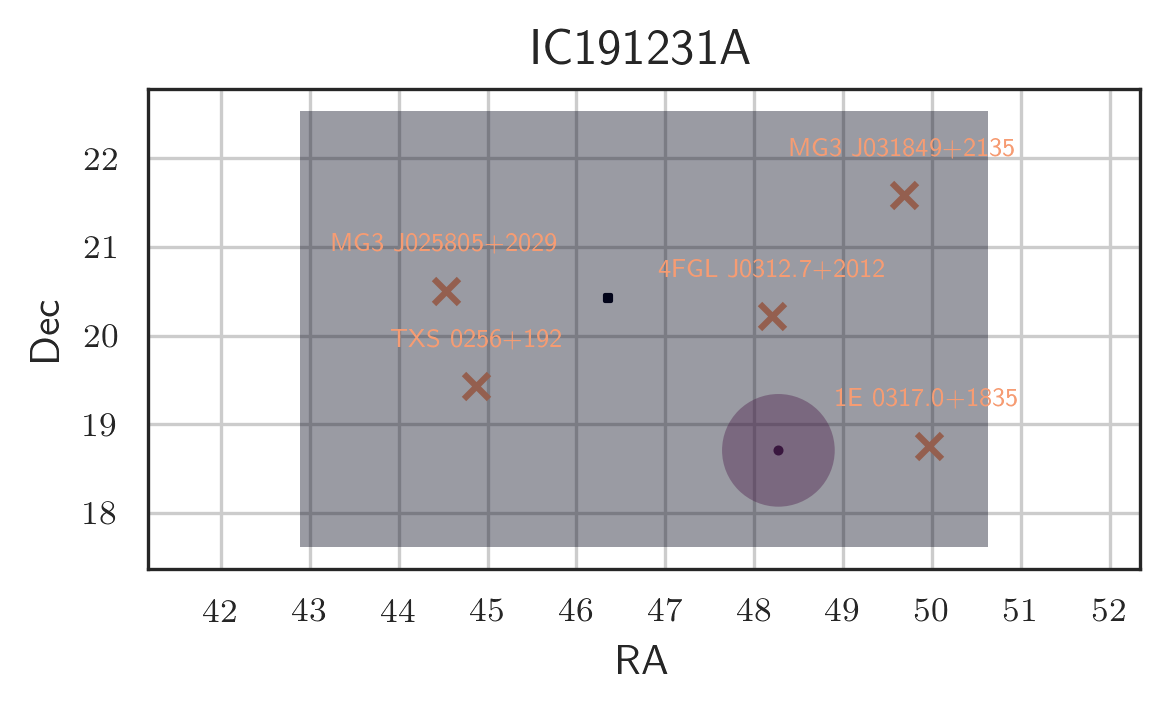

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J0955.1+3551  148.7816   35.8584 1RXS J095508.2+355054         148.782844217   35.8502411861 0.8859962224960327 148.782844217 35.8502411861
                   4FGL J0957.8+3423  149.4707   34.3975 B2 0954+34                    149.443714317   34.3709143306 0.9248281121253967 149.443714317 34.3709143306


ValueError: need at least one array to concatenate

<Figure size 1200x741.656 with 1 Axes>

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J1055.7+1033  163.9269   10.5546                                                                            0.0      163.9269       10.5546
3FHL J1103.1+1156  4FGL J1103.0+1157  165.7722   11.9654 TXS 1100+122                  165.764707638   11.9712846361 0.9733392596244812 165.764707638 11.9712846361
                   4FGL J1114.6+1225   168.664   12.4184                                                                            0.0       168.664       12.4184


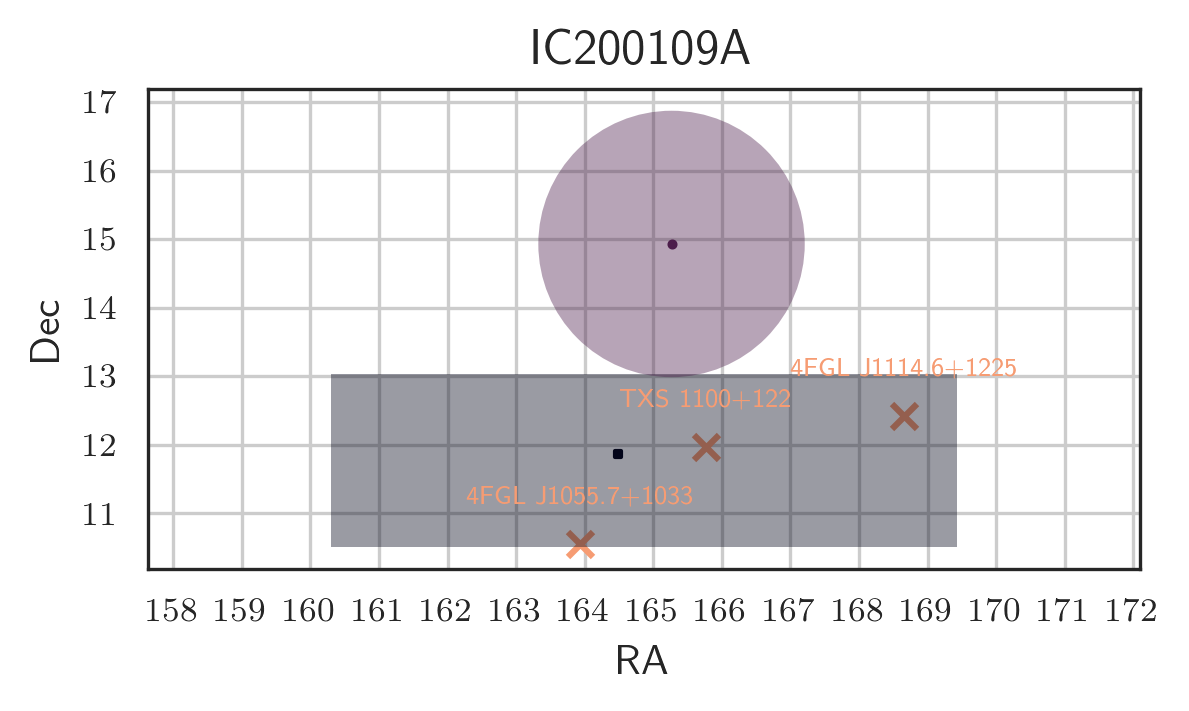

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart     Counterpart ra    Counterpart dec   Counterpart prob                 ra                dec
                   4FGL J1518.4+0750  229.6107    7.8446 NVSS J151826+075219           229.6111297607422 7.8729166984558105 0.8665623664855957  229.6111297607422 7.8729166984558105
                   4FGL J1518.6+0614  229.6503    6.2419 TXS 1516+064                      229.690532537      6.23225246667  0.956062376499176      229.690532537      6.23225246667
3FHL J1523.2+0533  4FGL J1523.2+0533  230.8241    5.5569 NVSS J152312+053357               230.803246637      5.56540876667                nan           230.8241             5.5569
                   4FGL J1525.7+1503  231.4375   15.0509                                                                                   0.0           231.4375            15.0509
                   4FGL J1527.8+1013  231.9709   10.2286                                       

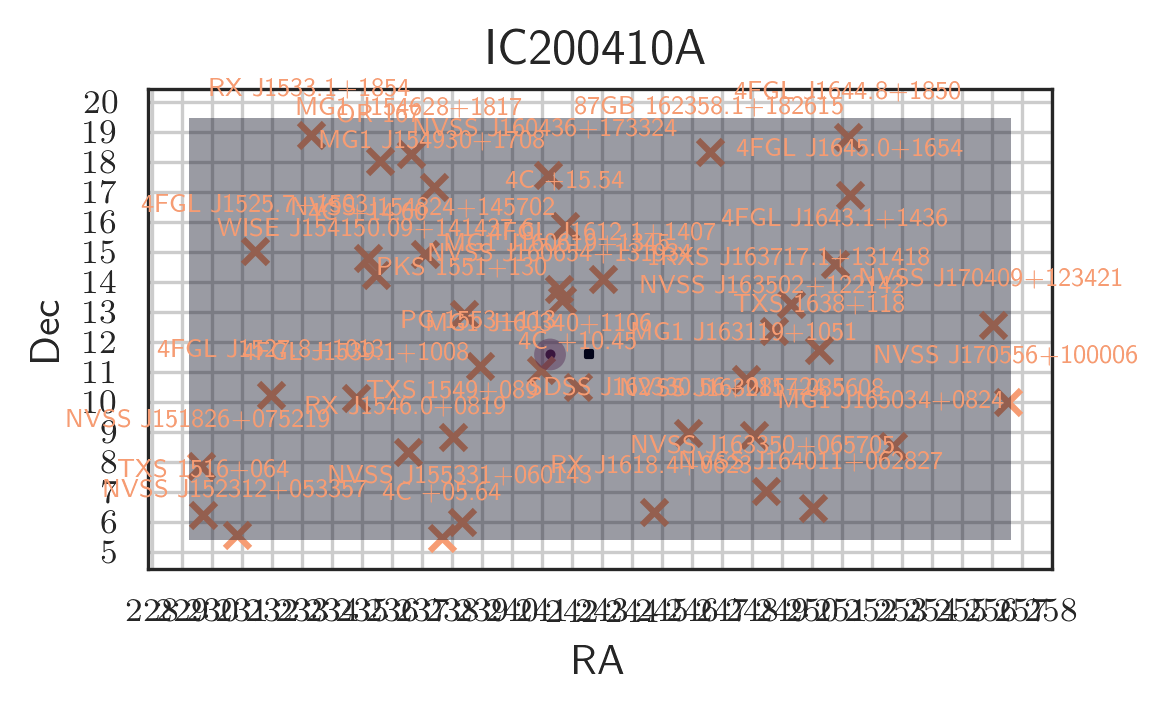

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart     Counterpart ra     Counterpart dec   Counterpart prob            ra              dec
3FHL J2211.0-0003  4FGL J2211.0-0003  332.7625   -0.0635 RX J2211.1-0003                   332.784769258    -0.0506958972222 0.9464753866195679 332.784769258 -0.0506958972222
1FHL J2223.4+0104  4FGL J2223.3+0102  335.8476    1.0476 SDSS J222329.56+010226.6          335.873212313       1.04073617778                0.0      335.8476           1.0476
                   4FGL J2226.6+0210   336.665     2.168 2MASS J22263636+0210373            336.65181465       2.17703532778 0.9200066924095154  336.65181465    2.17703532778
                   4FGL J2226.8+0051  336.7125    0.8622 PKS B2224+006                     336.693904225      0.869814322222 0.9511913061141968 336.693904225   0.869814322222
3FHL J2227.8+0036  4FGL J2227.9+0036  336.9843    0.6166 PMN J2227+0037                    336.992213454      0.618174211111 

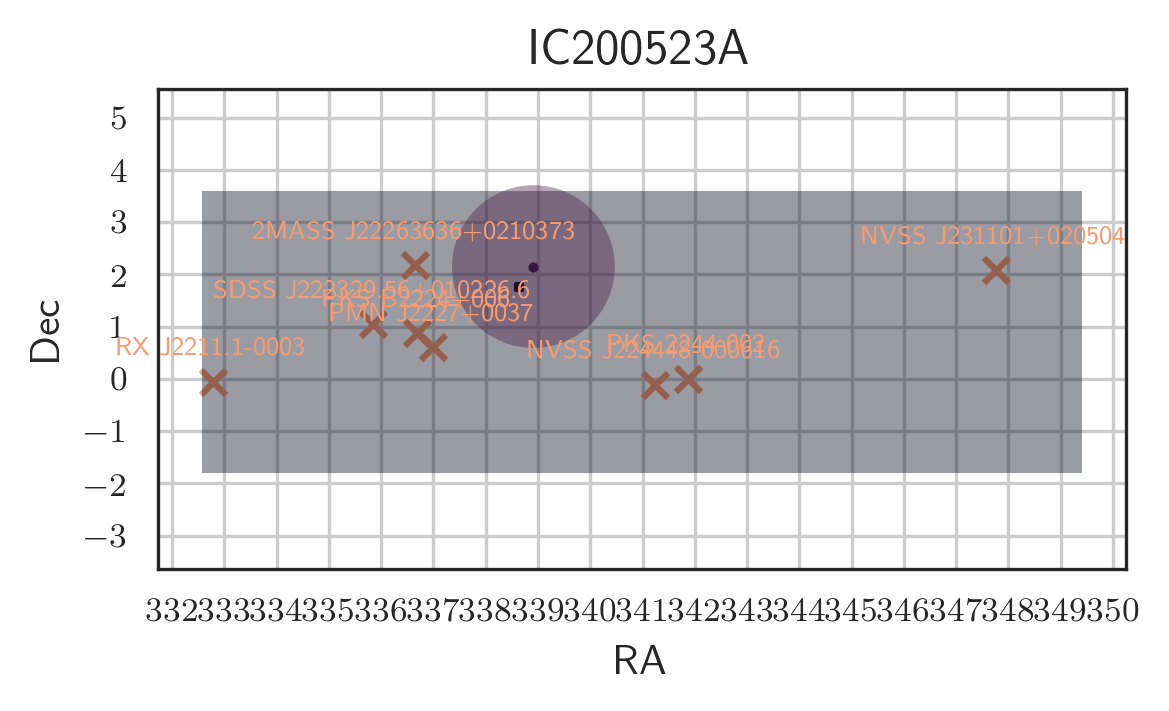

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J1659.0+2627  254.7699   26.4639 4C +26.51                      254.85062275   26.4935953083 0.8977105021476746  254.85062275 26.4935953083
                   4FGL J1702.2+2642  255.5583   26.7116 MG2 J170210+2643              255.540138825   26.7207481139 0.8328406810760498 255.540138825 26.7207481139


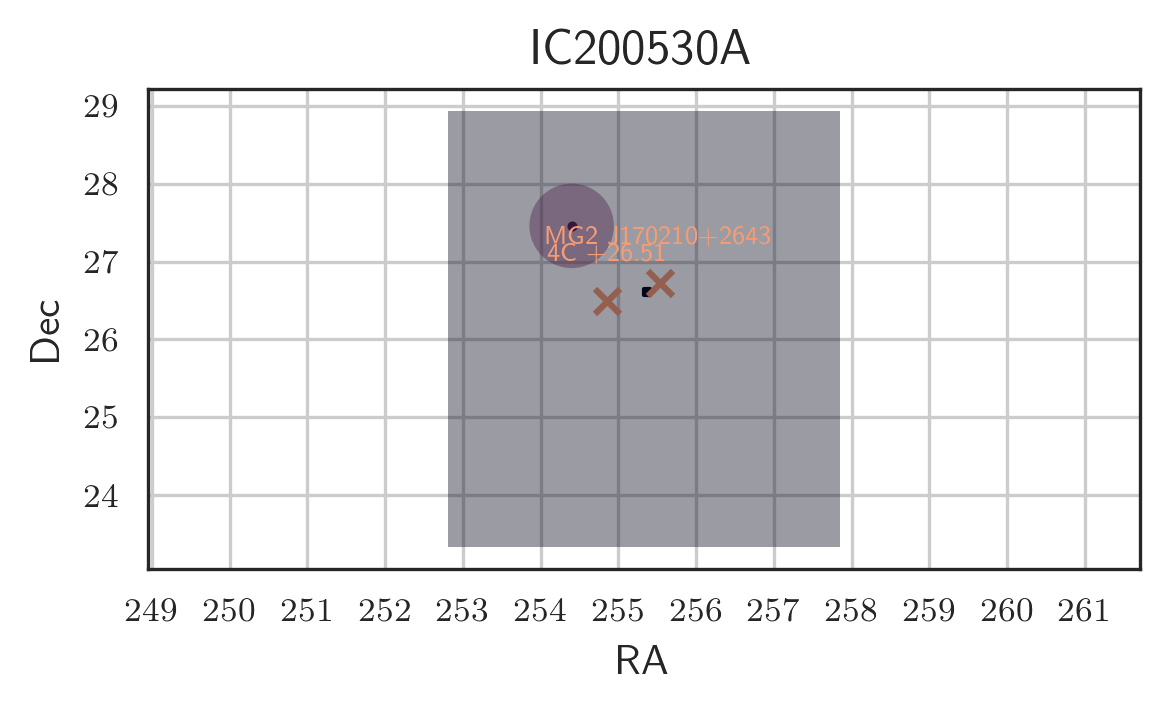

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
3FHL J0158.8+3314  4FGL J0159.0+3313   29.7665   33.2175                                                                            0.0       29.7665       33.2175
                   4FGL J0202.4+2943   30.6203   29.7292                                                                            0.0       30.6203       29.7292
3FHL J0203.8+3044  4FGL J0203.7+3042   30.9327   30.7139 NVSS J020344+304238           30.9344611875   30.7105101417  0.977444052696228 30.9344611875 30.7105101417
                   4FGL J0205.2+3212   31.3089    32.203 B2 0202+31                    31.2705223625   32.2083598639  0.960515558719635 31.2705223625 32.2083598639
                   4FGL J0220.2+3246    35.073   32.7793 CRATES J022048+324116            35.2002209   32.6851288306 0.8128966093063354    35.2002209 32.6851288306
                

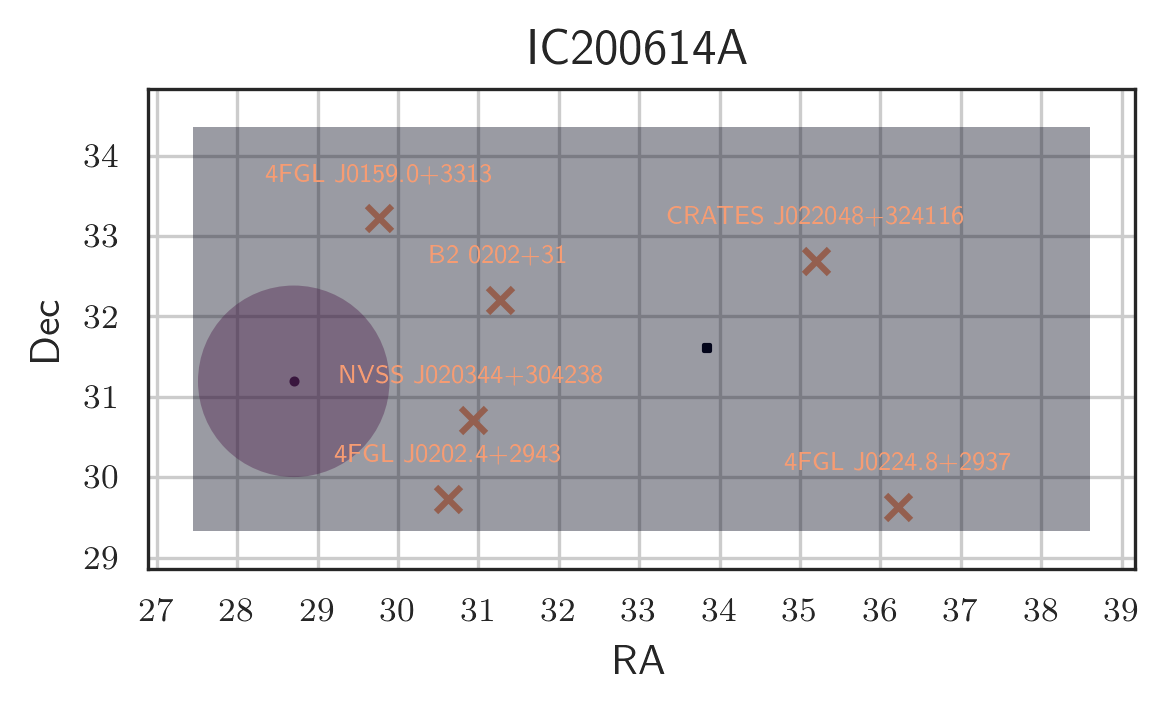

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J0252.9+3834   43.2466   38.5774 B2 0249+38                    43.2870336375   38.5902775528 0.9556704163551331 43.2870336375 38.5902775528
                   4FGL J0310.9+3815   47.7297   38.2552 B3 0307+380                    47.707833025   38.2482883083  0.943111777305603  47.707833025 38.2482883083
3FHL J0312.8+3614  4FGL J0312.9+3614   48.2276   36.2341 V Zw 326                        48.20953275   36.2554288139 0.9480661153793335   48.20953275 36.2554288139
                   4FGL J0333.8+4007   53.4658   40.1196 B3 0330+399                   53.4450770375   40.1107207278 0.8700571656227112 53.4450770375 40.1107207278
3FHL J0334.3+3920  4FGL J0334.3+3920   53.5823   39.3389 4C +39.12                     53.5767292667   39.3567794389 0.9846399426460266 53.5767292667 39.3567794389


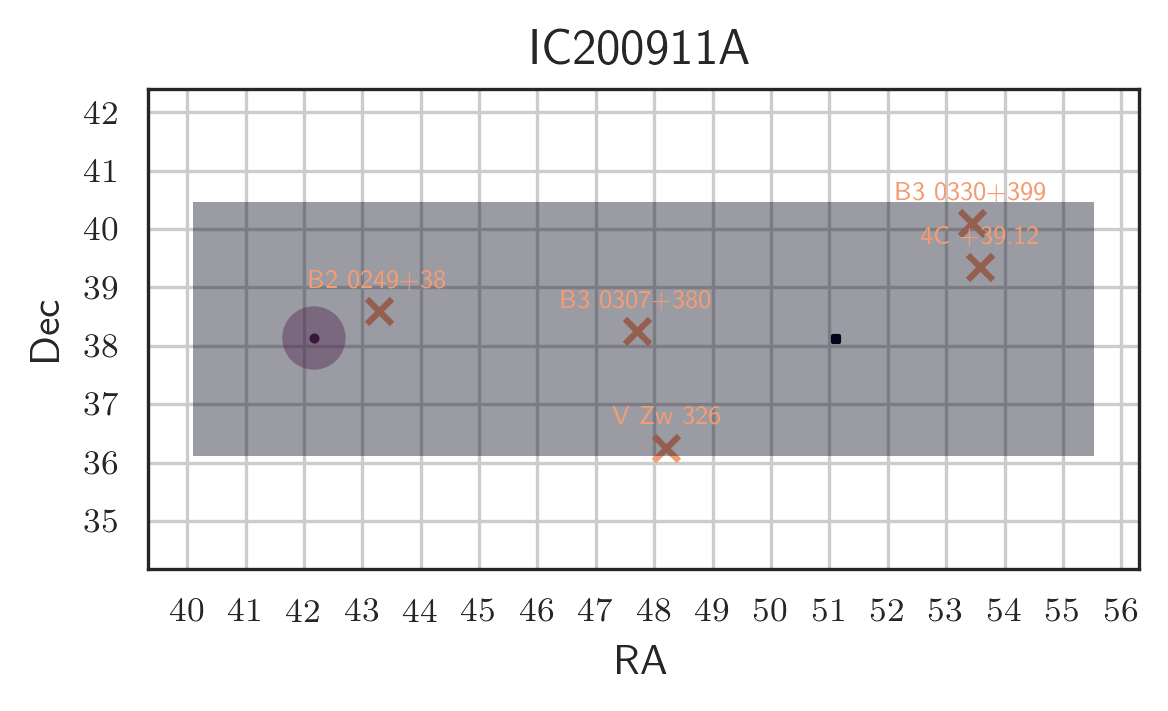

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra          dec
                   4FGL J1256.9+2736  194.2417   27.6076                                                                            0.0      194.2417      27.6076
3FHL J1303.0+2435  4FGL J1303.0+2434  195.7571   24.5821 MG2 J130304+2434              195.763404621    24.565480525 0.9132465124130249 195.763404621 24.565480525


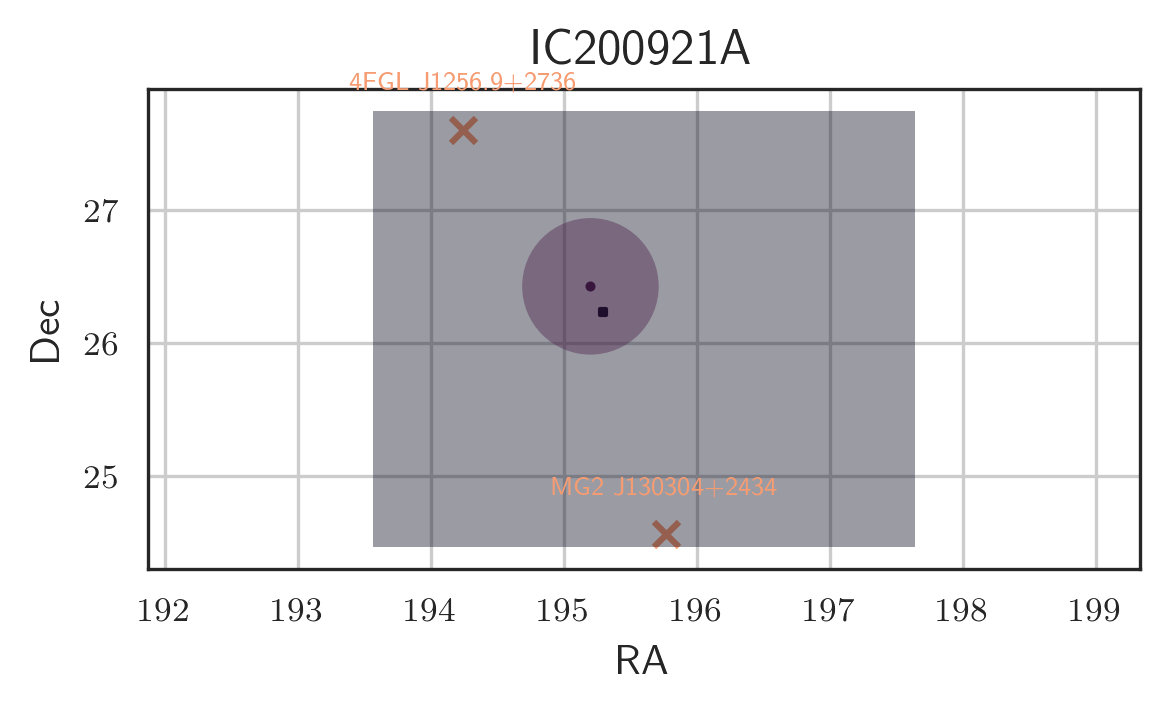

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec Counterpart prob       ra   dec
3FHL J0658.5+0636  4FGL J0658.6+0636  104.6599     6.611 NVSS J065844+063711           104.687599175   6.61985833333              0.0 104.6599 6.611


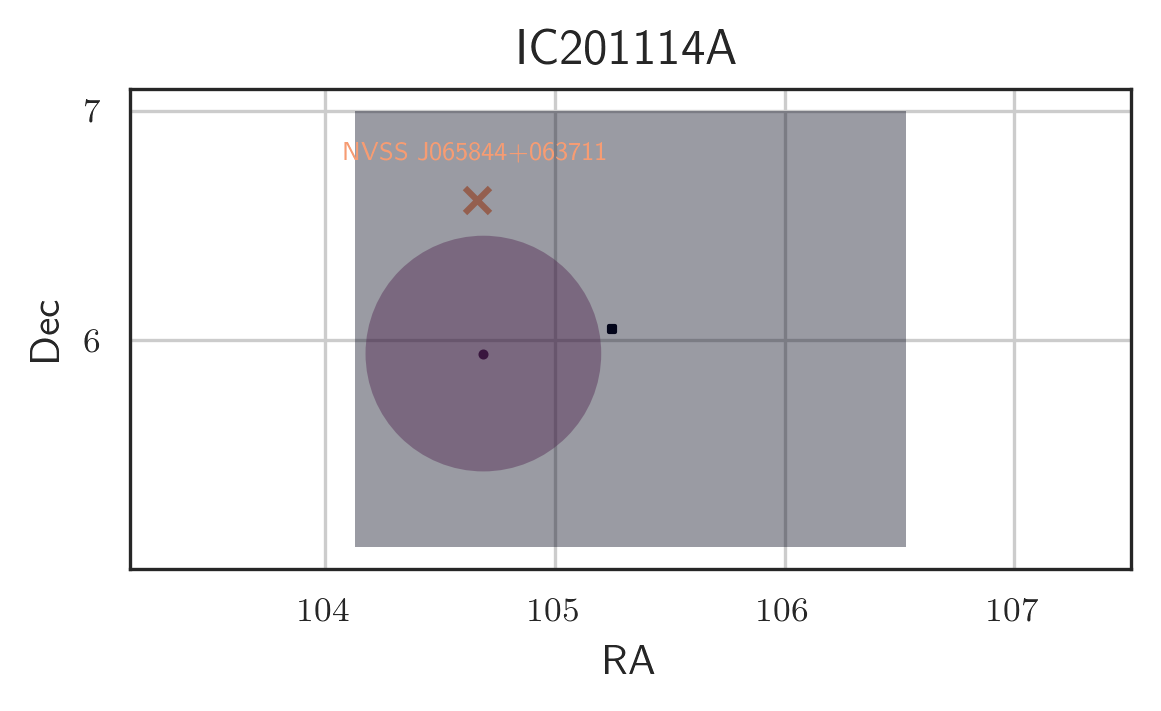

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart    Counterpart ra    Counterpart dec   Counterpart prob                ra                dec
3FHL J2018.5+3851  4FGL J2018.5+3852  304.6373   38.8715 TXS 2016+386                     304.629267683      38.8553835722 0.9510104656219482     304.629267683      38.8553835722
3FHL J2021.0+4031e 4FGL J2021.0+4031e   305.27     40.52 gamma Cygni                  305.2099914550781  40.43000030517578                nan            305.27              40.52
3FHL J2021.5+4026  4FGL J2021.5+4026  305.3851   40.4445 PSR J2021+4026                         305.375 40.445899963378906  0.980392336845398           305.375 40.445899963378906
                   4FGL J2022.3+3840  305.5845   38.6711 PSR J2022+3842               305.5899963378906  38.70399856567383 0.9495965838432312 305.5899963378906  38.70399856567383
                   4FGL J2023.4+4127  305.8711   41.4508 SSTSL2 J202336.19+412527.0         305.9006829  

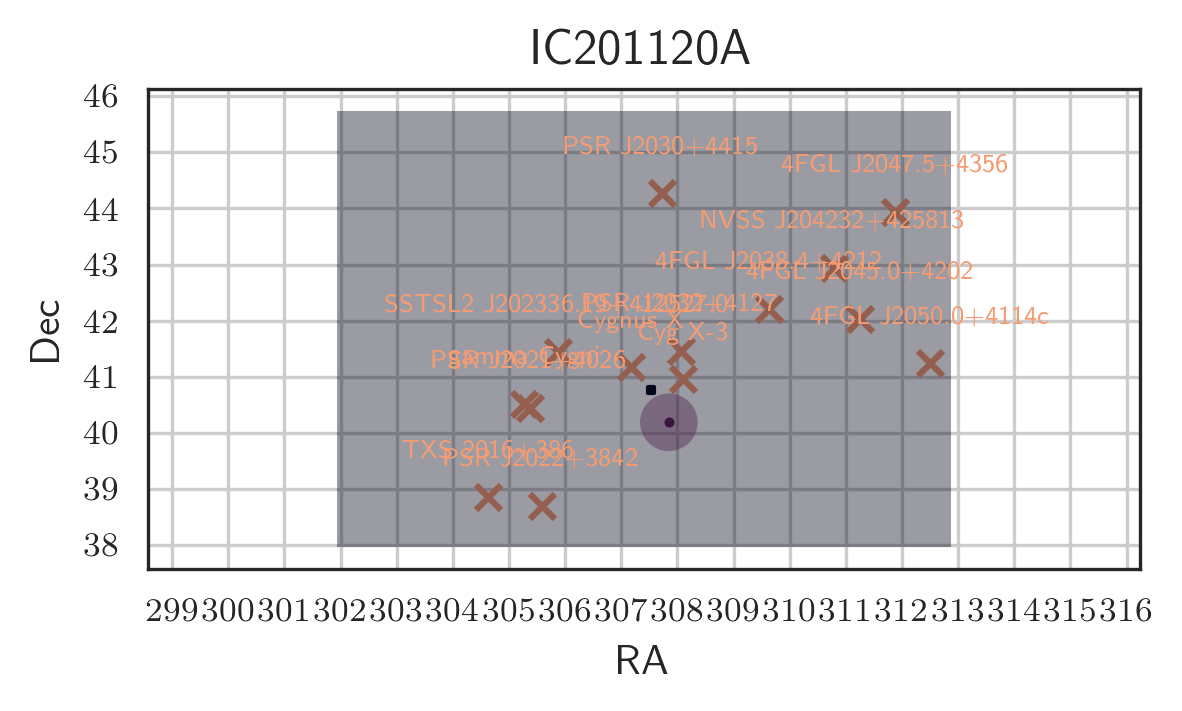

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob         ra            dec
                   4FGL J0206.4-1151   31.6018  -11.8576 PMN J0206-1150                   31.6086864  -11.8443678972 0.9685593843460083 31.6086864 -11.8443678972


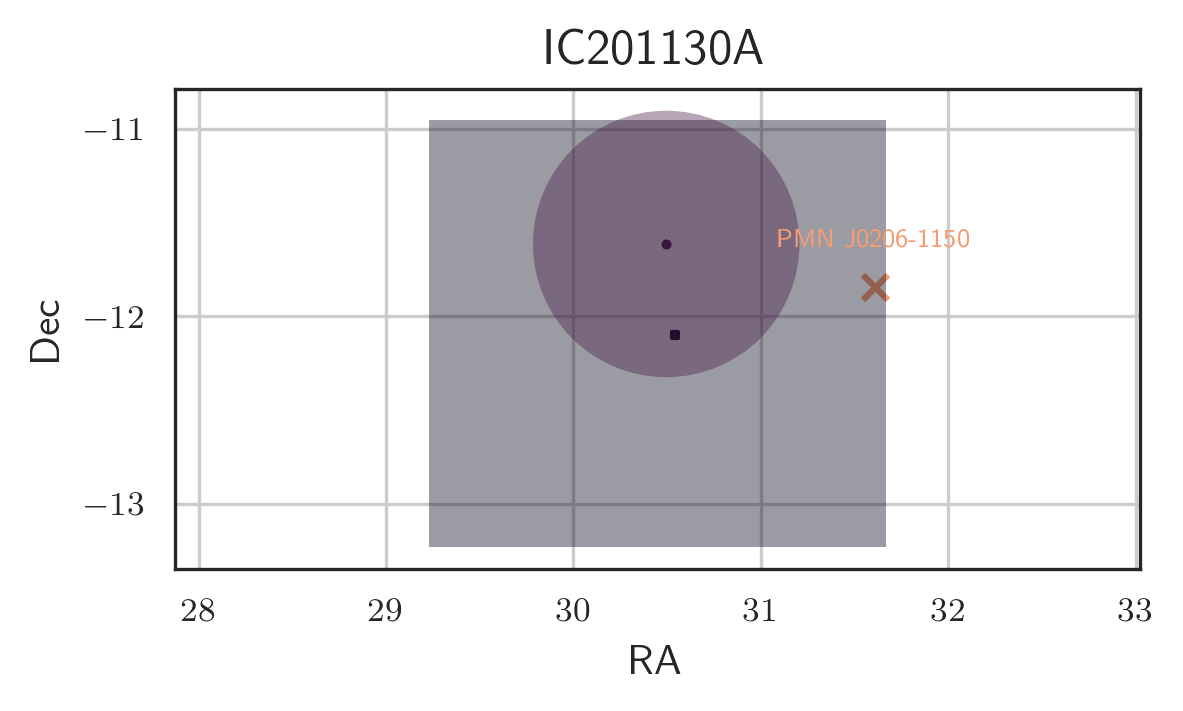

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
                   4FGL J1342.7+0505  205.6851    5.0904 4C +05.57                     205.681764358   5.07561691944 0.9830988645553589 205.681764358 5.07561691944


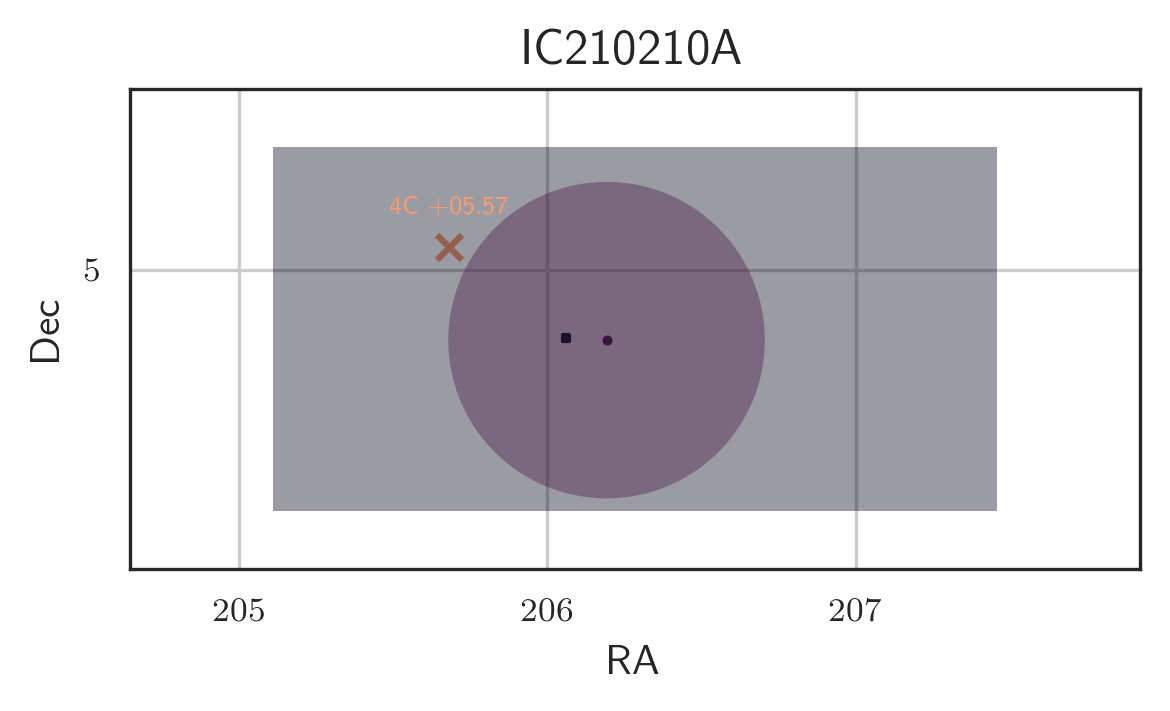

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart     Counterpart ra    Counterpart dec   Counterpart prob                ra               dec
                   4FGL J0916.7+3856  139.1898   38.9479 4C +38.28                         139.203769137      38.9078184722  0.942870557308197     139.203769137     38.9078184722
3FHL J0920.8+4442  4FGL J0920.9+4441  140.2291    44.699 S4 0917+44                        140.243577025      44.6983291833 0.9931305646896362     140.243577025     44.6983291833
                   4FGL J0922.6+4454  140.6588   44.9131 NVSS J092235+445749               140.645897875      44.9636320056                0.0          140.6588           44.9131
                   4FGL J0923.5+3852   140.885   38.8743 B2 0920+39                        140.810220563      38.8277528028                0.0           140.885           38.8743
                   4FGL J0923.5+4125  140.8949   41.4283 B3 0920+416                       140.880437333 

ValueError: need at least one array to concatenate

<Figure size 1200x741.656 with 1 Axes>

         3FHL Name          4FGL Name Fermi ra Fermi dec Counterpart Counterpart ra Counterpart dec Counterpart prob       ra    dec
                   4FGL J1747.6+0324  266.9051    3.4073                                                         0.0 266.9051 3.4073


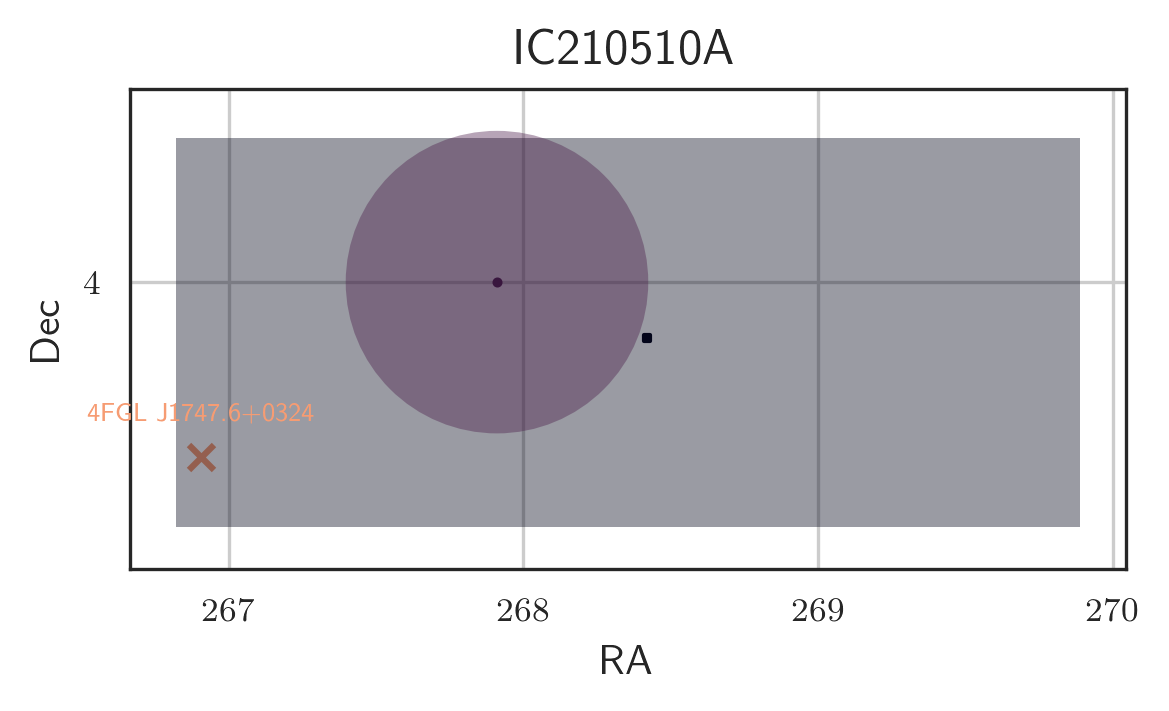

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra           dec
3FHL J2143.5+1742  4FGL J2143.5+1743  325.8942   17.7306 OX 169                        325.898102354   17.7302187806  0.994395911693573 325.898102354 17.7302187806
                   4FGL J2149.7+1917  327.4441   19.2859 TXS 2147+191                  327.446868625   19.3461996611                0.0      327.4441       19.2859
                   4FGL J2152.5+1737   328.137   17.6173 S3 2150+17                    328.103414142      17.5771653 0.9438310265541077 328.103414142    17.5771653
3FHL J2156.0+1818  4FGL J2156.0+1818   329.013    18.309 RX J2156.0+1818               329.006833596    18.310318025 0.9806545376777649 329.006833596  18.310318025
3FHL J2200.2+2137  4FGL J2200.1+2138  330.0307   21.6382 TXS 2157+213                  330.059155833   21.6325108333 0.9190321564674377 330.059155833 21.6325108333
3FHL J2203.4+172

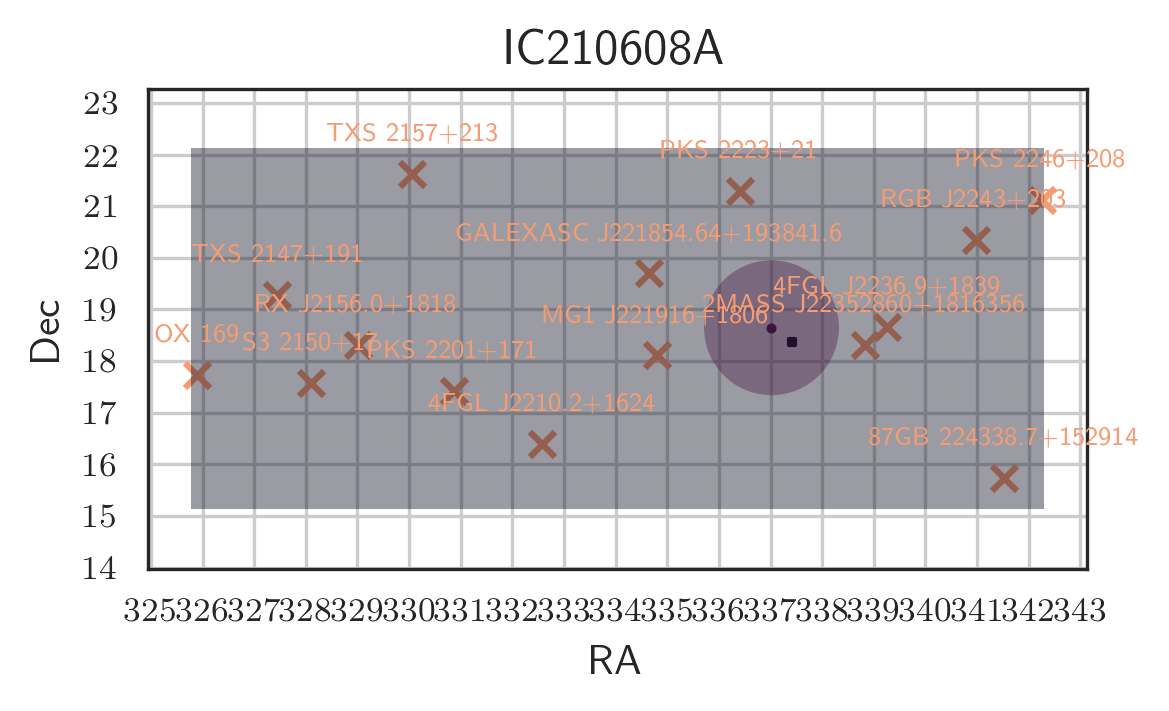

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart Counterpart ra Counterpart dec   Counterpart prob            ra            dec
                   4FGL J0256.2-0408   44.0544    -4.134                                                                            0.0       44.0544         -4.134
3FHL J0304.5-0055  4FGL J0304.5-0054   46.1423   -0.9148 RX J0304.5-0054               46.1414966667     -0.90130895 0.9383262395858765 46.1414966667    -0.90130895
                   4FGL J0307.8-0419   46.9523   -4.3266 LEDA 095522                   46.9354854083  -4.31923459167 0.8354509472846985 46.9354854083 -4.31923459167


ValueError: need at least one array to concatenate

<Figure size 1200x741.656 with 1 Axes>

         3FHL Name          4FGL Name Fermi ra Fermi dec                  Counterpart    Counterpart ra    Counterpart dec   Counterpart prob                ra                dec
                   4FGL J0659.7+1416  104.9416   14.2792 PSR J0659+1414               104.9505615234375 14.239310264587402 0.9872325658798218 104.9505615234375 14.239310264587402


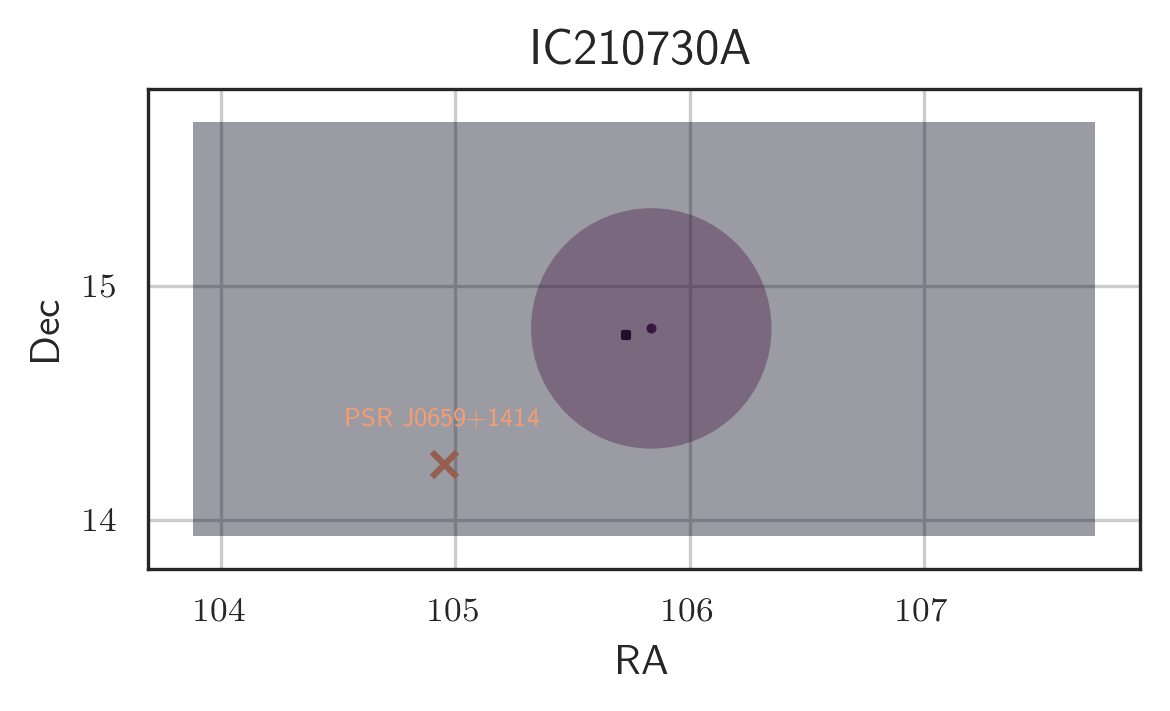

In [7]:
cmap = plt.get_cmap()

for i, r in alerts.iterrows():
    
    try:
        sources = fermi_matches.loc[pd.IndexSlice[r.Event, :, :]]
    except KeyError:
        continue
    
    sources = sources[~sources['4FGL Name'].isna()]
    
    if len(sources) > 0:
        print(sources.to_string(index=False))

        fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)

        ax.set_aspect(1, adjustable='datalim')
        ax.scatter(r['RA'], r['Dec'], color=cmap(0), marker='s', s=2)
        if r['RA Unc (rectangle) float'] and r['Dec Unc (rectangle) float']:
            left_bottom_corner = (r['RA'] + r['RA Unc (rectangle) float'][1], r['Dec'] + r['Dec Unc (rectangle) float'][1])
            extent = (r['RA Unc (rectangle) float'][0] - r['RA Unc (rectangle) float'][1],
                      r['Dec Unc (rectangle) float'][0] - r['Dec Unc (rectangle) float'][1])
            final_e = plt.Rectangle(left_bottom_corner, extent[0], extent[1], fc=cmap(0), alpha=0.4, ec=None, ls='')
            ax.add_patch(final_e)
        else:
            print(r)

        ax.scatter(r['initial RA'], r['initial Dec'], color=cmap(0.2), s=2)
        initial_e = r['initial Error90 [arcmin]'] * u.arcmin
        initial_contour = plt.Circle((r['initial RA'], r['initial Dec']), initial_e.to('deg').value, alpha=0.4, fc=cmap(0.2), ec=None, ls='')
        ax.add_patch(initial_contour)

        ax.scatter(np.array(sources['ra']).astype(float), 
                   np.array(sources['dec']).astype(float), marker='x', color=cmap(0.8))
        fgl = ~sources['4FGL Name'].isna()
        for _, s in sources[fgl].iterrows():
            ylim = ax.get_ylim()
            yext = abs(ylim[1] - ylim[0])
            n = s['Counterpart'] if s['Counterpart'] else s['4FGL Name']
            ax.annotate(n, (float(s.ra), float(s.dec) + yext/12), ha='center', color=cmap(0.8), fontsize=6,
                       snap=True)

        ax.set_title(r.Event)
        major_base = 20 if r.Event=="IC190331A" in cc else 1
        ax.xaxis.set_major_locator(MultipleLocator(base=major_base))
        ax.yaxis.set_major_locator(MultipleLocator(base=major_base))
        ax.grid()

        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')


        fig.tight_layout()
        fig.savefig(os.path.join(output_folder, f"{r.Event}.pdf"))
        try:
            plt.show()
        finally:
            plt.close()

In [6]:
fgl = fits.open("data/gll_psc_v27.fit")
fgltab = fgl[1].data

In [38]:
txsm = fgltab['ASSOC1'] == 'TXS 0506+056'
txs = fgltab[txsm]
txs.columns

ColDefs(
    name = 'Source_Name'; format = '18A'
    name = 'DataRelease'; format = 'I'; null = 16959
    name = 'RAJ2000'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'DEJ2000'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'GLON'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'GLAT'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_SemiMajor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_SemiMinor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_PosAng'; format = 'E'; unit = 'deg'; disp = 'F8.3'
    name = 'Conf_95_SemiMajor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_95_SemiMinor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_95_PosAng'; format = 'E'; unit = 'deg'; disp = 'F8.3'
    name = 'ROI_num'; format = 'I'; null = 16959
    name = 'Extended_Source_Name'; format = '18A'
    name = 'Signif_Avg'; format = 'E'; disp = 'F8.3'
    name = 'Pivot_Energy'; format = 'E'; unit = 'MeV'; di

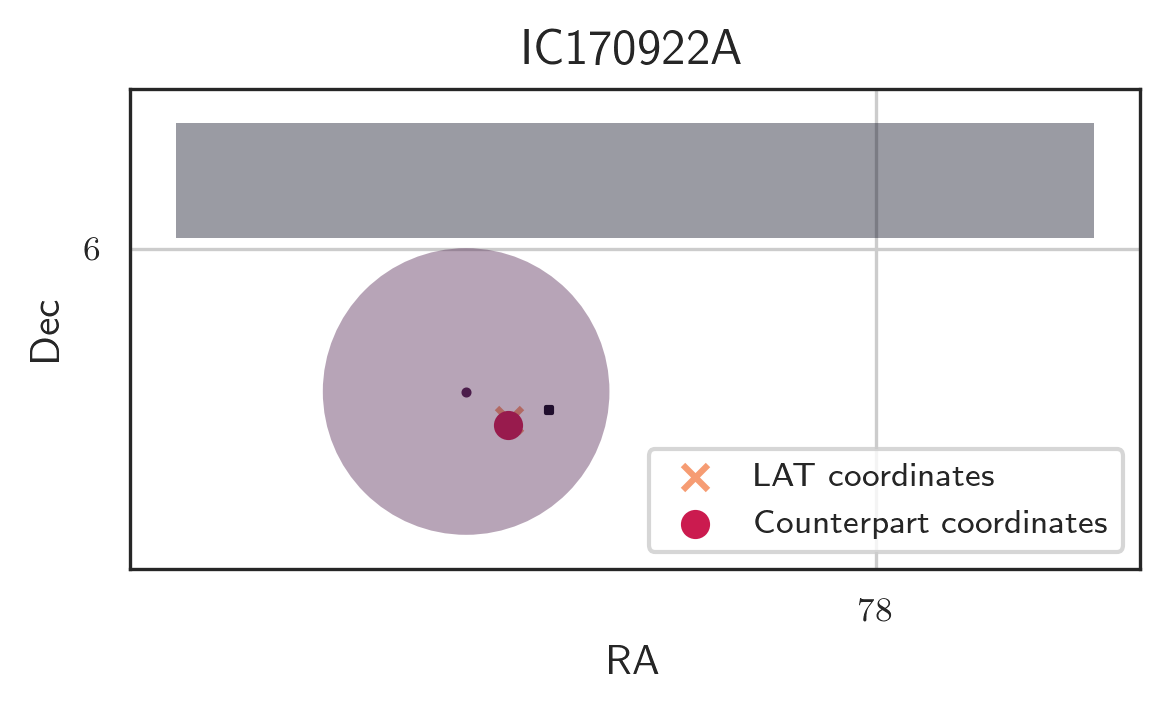

In [40]:

r = pd.Series(alerts.loc[alerts.Event == 'IC170922A'].iloc[0])
fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)

ax.set_aspect(1, adjustable='datalim')
ax.scatter(r['RA'], r['Dec'], color=cmap(0), marker='s', s=2)
left_bottom_corner = (r['RA'] + r['RA Unc (rectangle) float'][1], r['Dec'] + r['Dec Unc (rectangle) float'][1])
extent = (r['RA Unc (rectangle) float'][0] - r['RA Unc (rectangle) float'][1],
          r['Dec Unc (rectangle) float'][0] - r['Dec Unc (rectangle) float'][1])
final_e = plt.Rectangle(left_bottom_corner, extent[0], extent[1], fc=cmap(0), alpha=0.4, ec=None, ls='')
ax.add_patch(final_e)

ax.scatter(r['initial RA'], r['initial Dec'], color=cmap(0.2), s=2)
initial_e = r['initial Error90 [arcmin]'] * u.arcmin
initial_contour = plt.Circle((r['initial RA'], r['initial Dec']), initial_e.to('deg').value, alpha=0.4, fc=cmap(0.2), ec=None, ls='')
ax.add_patch(initial_contour)

ax.scatter(txs['RAJ2000'], txs['DEJ2000'], label='LAT coordinates', marker='x', color=cmap(0.8))
ax.scatter(txs['RA_Counterpart'], txs['DEC_Counterpart'], label='Counterpart coordinates', marker='o', color=cmap(0.5))

ax.set_title(r.Event)
major_base = 20 if r.Event=="IC190331A" in cc else 2
ax.xaxis.set_major_locator(MultipleLocator(base=major_base))
ax.yaxis.set_major_locator(MultipleLocator(base=major_base))
ax.grid()
ax.legend()

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

fig.tight_layout()
fig.savefig(os.path.join(output_folder, f"{r.Event}.pdf"))
plt.show()
plt.close()

In [41]:
r

Event                                     IC170922A
Class                                           EHE
RA                                            77.43
RA Unc (rectangle)                    [0.95, -0.65]
Dec                                            5.72
Dec Unc (rectangle)                    [0.50, 0.30]
arrival time [UT]            2017-09-22 20:54:30.43
Signalness                                  0.56507
initial RA                                  77.2853
initial Dec                                  5.7517
initial Error90 [arcmin]                      14.99
retracted                                     False
RA Unc (rectangle) float              [0.95, -0.65]
Dec Unc (rectangle) float                [0.5, 0.3]
2h coverage                                     0.0
14d coverage                                  100.0
observed                                       True
Name: 32, dtype: object